In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, List

import pandas as pd
import numpy as np

import re

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW
import transformers

from transformers import (ElectraForSequenceClassification,
                          ElectraTokenizerFast,
                          EvalPrediction,
                          InputFeatures,
                          Trainer,
                          TrainingArguments,
                          get_linear_schedule_with_warmup)

import tweetnlp
import tweetnlp.text_classification
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader

In [9]:
class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer

        # Tokenize the input
        self.tokenized_inputs = tokenizer(inputs, padding=True)   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
            token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])

# function to perform basic preprocessing
def preprocess(inputs: list) -> list:
    outputs = []

    for input in inputs:
        # remove '@user' tags as these are present in almost every tweet
        input = re.sub(r"@user", "", input)
        # reformat emojis from [token]\uxxxx to [token][space]\uxxx
        input = re.sub(r"\\u", r" \\u", input)
        # remove select punctuation
        input = re.sub(r"[\.|'|\"|,]", "", input)
        # convert &amp; into &
        input = re.sub(r"&amp;", "&", input)
        
        outputs.append(input)

    return outputs


def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision': precision_recall_fscore_support(p.label_ids, preds, average='weighted')[0],
        'recall': precision_recall_fscore_support(p.label_ids, preds, average='weighted')[1],
        'f1': precision_recall_fscore_support(p.label_ids, preds, average='weighted')[2],
        'mathews' : matthews_corrcoef(p.label_ids, preds),
    }

def data_collator(features: List[InputFeatures]) -> Dict[str, torch.Tensor]:
    batch = {}
    batch["input_ids"] = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    batch["attention_mask"] = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    batch["token_type_ids"] = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    batch["labels"] = torch.tensor([f.label for f in features], dtype=torch.long)
    return batch

In [10]:
# function to perform basic preprocessing
def preprocess(inputs: list) -> list:
    outputs = []

    for input in inputs:
        # remove '@user' tags as these are present in almost every tweet
        input = re.sub(r"@user", "", input)
        # reformat emojis from [token]\uxxxx to [token][space]\uxxx
        input = re.sub(r"\\u", r" \\u", input)
        # remove select punctuation
        input = re.sub(r"[\.|'|\"|,]", "", input)
        # convert &amp; into &
        input = re.sub(r"&amp;", "&", input)
        
        outputs.append(input)

    return outputs

tokeniser = ElectraTokenizerFast.from_pretrained("google/electra-small-discriminator", do_lower_case=True)
dataset, labels = tweetnlp.load_dataset('sentiment')
train_dataset = TrainerDataset(preprocess(dataset["train"]["text"]), dataset["train"]["label"], tokeniser)
test_dataset = TrainerDataset(preprocess(dataset["test"]["text"]), dataset["test"]["label"], tokeniser)
val_dataset = TrainerDataset(preprocess(dataset["validation"]["text"]), dataset["validation"]["label"], tokeniser)


Found cached dataset tweet_eval (C:/Users/willw/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

In [80]:
class TestBench1():

    def __init__(self, num_train_epochs=3, per_device_train_batch_size=64):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = ElectraForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels = 3)
        model.to(device)
                
        training_args = TrainingArguments(
                output_dir="./models/model_electra",
                num_train_epochs=num_train_epochs,  # 1 (1 epoch gives slightly lower accuracy)
                overwrite_output_dir=True,
                do_train=True,
                do_eval=True,
                per_device_train_batch_size=per_device_train_batch_size,
                dataloader_drop_last=True,  # Make sure all batches are of equal size
                evaluation_strategy="steps",
            )
        self.num_train_epochs = num_train_epochs
        self.per_device_train_batch_size = per_device_train_batch_size


        self.trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        # Train the model
        self.trainer.train()

def report(tb, batchsize):

    # Get the training logs
    logs = tb.trainer.state.log_history
    final_time = -1
    ymin = 999
    ymax = -999
    # Extract the loss values for each epoch
    train_history, test_history, lr_history, mcc_history, accuracy_history, precision_history,recall_history, f1_history = {},{},{},{},{},{},{},{}
    for log in logs:
        if log.get('loss'):
            train_history[log.get('epoch')] = log.get('loss')
        if log.get('eval_loss'):
            test_history[log.get('epoch')] = log.get('eval_loss')
        if log.get('learning_rate'):
            lr = log.get('learning_rate')
            lr_history[log.get('epoch')] = lr
            if lr > ymax: ymax = lr
            if lr < ymin: ymin = lr
        if log.get('train_runtime'):
            final_time = log.get('train_runtime')
        if log.get('eval_mathews'):
            mcc_history[log.get('epoch')] = log.get('eval_mathews')
        if log.get('eval_accuracy'):
            accuracy_history[log.get('epoch')] = log.get('eval_accuracy')
        if log.get('eval_precision'):
            precision_history[log.get('epoch')] = log.get('eval_precision')
        if log.get('eval_recall'):
            recall_history[log.get('epoch')] = log.get('eval_recall')
        if log.get('eval_f1'):
            f1_history[log.get('epoch')] = log.get('eval_f1')

    # Plot the loss curves and learning rates
    fig, axs = plt.subplots(1, 3, figsize = (25, 7))
    axs[0].plot(train_history.keys(), train_history.values(), label='Training loss')
    axs[0].plot(test_history.keys(), test_history.values(), label='Test loss')
    axs[0].plot(mcc_history.keys(), mcc_history.values(), label='Test Mathews coef')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(lr_history.keys(), lr_history.values())
    axs[1].set_ylim(ymin, ymax)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Learning rate')
    axs[1].legend()

    axs[2].plot(accuracy_history.keys(), accuracy_history.values(), label='Accuracy', linestyle=':')
    axs[2].plot(precision_history.keys(), precision_history.values(), label='Precision', linestyle=':')
    axs[2].plot(recall_history.keys(), recall_history.values(), label='Recall',linestyle=':')
    axs[2].plot(f1_history.keys(), f1_history.values(), label='F1-Score',linestyle=':')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Score')
    
    axs[2].legend()

    fig.suptitle(f'Training and Evaluation Metrics: batchsize = {batchsize}, runtime = {final_time}s')

    plt.show()

def reportFinal(trainers):
    x = []
    y_loss = []
    y_acc = []
    y_f1 = []
    y_mathews = []
    labels = []
    bar_width = 0.2  # set the width of the bars
    for i, (k, v) in enumerate(trainers.items()):
        results = v.trainer.evaluate(val_dataset)
        x.append(i + 1)  # shift the x-coordinates for each group of bars
        y_loss.append(results['eval_loss'])
        y_acc.append(results['eval_accuracy'])
        y_f1.append(results['eval_f1'])
        y_mathews.append(results['eval_mathews'])
        labels.append(k)

    plt.bar(x, y_loss, width=bar_width, color='orange')
    plt.bar([xi + bar_width for xi in x], y_acc, width=bar_width, color='blue')
    plt.bar([xi + 2*bar_width for xi in x], y_f1, width=bar_width, color='red')
    plt.bar([xi + 3*bar_width for xi in x], y_mathews, width=bar_width, color='green')
    plt.legend(['Loss', 'Accuracy', 'F1', 'MCC'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(x, labels)  # set the x-tick labels
    plt.show()


#Test 1

Electra adviced, or pythorch infered hyperameters except epochs-=1
Increasing batchsize expecting to gauge overfitting - 16,32,64
Show Training and Testing plots of loss and mathews co-efficient over epochs, learning rate and of the accuracy metrics from testing over epochs.



Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/8550 [00:00<?, ?it/s]

{'loss': 0.8592, 'learning_rate': 4.707602339181287e-05, 'epoch': 0.18}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.8203774094581604, 'eval_accuracy': 0.6641693811074919, 'eval_precision': 0.6700071100263589, 'eval_recall': 0.6641693811074919, 'eval_f1': 0.6650914754674299, 'eval_mathews': 0.472468464041866, 'eval_runtime': 21.4386, 'eval_samples_per_second': 572.984, 'eval_steps_per_second': 71.646, 'epoch': 0.18}
{'loss': 0.7457, 'learning_rate': 4.4152046783625734e-05, 'epoch': 0.35}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7612735629081726, 'eval_accuracy': 0.6788273615635179, 'eval_precision': 0.6811669531985247, 'eval_recall': 0.6788273615635179, 'eval_f1': 0.6792984015095358, 'eval_mathews': 0.4895702371814828, 'eval_runtime': 21.558, 'eval_samples_per_second': 569.813, 'eval_steps_per_second': 71.25, 'epoch': 0.35}
{'loss': 0.7049, 'learning_rate': 4.12280701754386e-05, 'epoch': 0.53}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.8119296431541443, 'eval_accuracy': 0.6517915309446254, 'eval_precision': 0.6773202467417289, 'eval_recall': 0.6517915309446254, 'eval_f1': 0.6427890052912985, 'eval_mathews': 0.44552787309593894, 'eval_runtime': 21.4287, 'eval_samples_per_second': 573.249, 'eval_steps_per_second': 71.679, 'epoch': 0.53}
{'loss': 0.6871, 'learning_rate': 3.8304093567251465e-05, 'epoch': 0.7}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7275926470756531, 'eval_accuracy': 0.6740228013029316, 'eval_precision': 0.6799405724089974, 'eval_recall': 0.6740228013029316, 'eval_f1': 0.674752751539868, 'eval_mathews': 0.4904458306836683, 'eval_runtime': 21.5697, 'eval_samples_per_second': 569.503, 'eval_steps_per_second': 71.211, 'epoch': 0.7}
{'loss': 0.6693, 'learning_rate': 3.538011695906433e-05, 'epoch': 0.88}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.8024583458900452, 'eval_accuracy': 0.6612377850162866, 'eval_precision': 0.6721878125805307, 'eval_recall': 0.6612377850162866, 'eval_f1': 0.6576156837135507, 'eval_mathews': 0.4576743015091058, 'eval_runtime': 21.4226, 'eval_samples_per_second': 573.413, 'eval_steps_per_second': 71.7, 'epoch': 0.88}
{'loss': 0.6552, 'learning_rate': 3.24561403508772e-05, 'epoch': 1.05}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7239511609077454, 'eval_accuracy': 0.6824104234527687, 'eval_precision': 0.6850040459824916, 'eval_recall': 0.6824104234527687, 'eval_f1': 0.6827989435595134, 'eval_mathews': 0.4988711300663696, 'eval_runtime': 21.6156, 'eval_samples_per_second': 568.295, 'eval_steps_per_second': 71.06, 'epoch': 1.05}
{'loss': 0.5947, 'learning_rate': 2.9532163742690062e-05, 'epoch': 1.23}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.70647132396698, 'eval_accuracy': 0.6859934853420195, 'eval_precision': 0.688976171305308, 'eval_recall': 0.6859934853420195, 'eval_f1': 0.6855378824478273, 'eval_mathews': 0.5062012465268046, 'eval_runtime': 21.497, 'eval_samples_per_second': 571.429, 'eval_steps_per_second': 71.452, 'epoch': 1.23}
{'loss': 0.5908, 'learning_rate': 2.6608187134502928e-05, 'epoch': 1.4}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7268380522727966, 'eval_accuracy': 0.6896579804560261, 'eval_precision': 0.6915910089627195, 'eval_recall': 0.6896579804560261, 'eval_f1': 0.6892155806680524, 'eval_mathews': 0.5005601335604841, 'eval_runtime': 21.7668, 'eval_samples_per_second': 564.346, 'eval_steps_per_second': 70.566, 'epoch': 1.4}
{'loss': 0.5848, 'learning_rate': 2.368421052631579e-05, 'epoch': 1.58}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.6981877088546753, 'eval_accuracy': 0.6896579804560261, 'eval_precision': 0.6904330955405708, 'eval_recall': 0.6896579804560261, 'eval_f1': 0.6897107040088363, 'eval_mathews': 0.5030526456223638, 'eval_runtime': 21.4229, 'eval_samples_per_second': 573.405, 'eval_steps_per_second': 71.699, 'epoch': 1.58}
{'loss': 0.5693, 'learning_rate': 2.0760233918128656e-05, 'epoch': 1.75}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7517378330230713, 'eval_accuracy': 0.6776872964169381, 'eval_precision': 0.6837079088563194, 'eval_recall': 0.6776872964169381, 'eval_f1': 0.6776904248870943, 'eval_mathews': 0.49884741417274303, 'eval_runtime': 21.4714, 'eval_samples_per_second': 572.109, 'eval_steps_per_second': 71.537, 'epoch': 1.75}
{'loss': 0.5747, 'learning_rate': 1.7836257309941522e-05, 'epoch': 1.93}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7426546216011047, 'eval_accuracy': 0.6784201954397394, 'eval_precision': 0.6819716788202577, 'eval_recall': 0.6784201954397394, 'eval_f1': 0.6789113061748469, 'eval_mathews': 0.49225026629194035, 'eval_runtime': 21.4978, 'eval_samples_per_second': 571.408, 'eval_steps_per_second': 71.449, 'epoch': 1.93}
{'loss': 0.526, 'learning_rate': 1.4912280701754386e-05, 'epoch': 2.11}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7697156667709351, 'eval_accuracy': 0.6816775244299674, 'eval_precision': 0.685856652586777, 'eval_recall': 0.6816775244299674, 'eval_f1': 0.6820080020719975, 'eval_mathews': 0.5009988908064947, 'eval_runtime': 21.5328, 'eval_samples_per_second': 570.479, 'eval_steps_per_second': 71.333, 'epoch': 2.11}
{'loss': 0.4876, 'learning_rate': 1.1988304093567252e-05, 'epoch': 2.28}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7522335052490234, 'eval_accuracy': 0.6909609120521173, 'eval_precision': 0.6912255471294231, 'eval_recall': 0.6909609120521173, 'eval_f1': 0.6909015514873604, 'eval_mathews': 0.5067696823711144, 'eval_runtime': 21.3958, 'eval_samples_per_second': 574.132, 'eval_steps_per_second': 71.79, 'epoch': 2.28}
{'loss': 0.4965, 'learning_rate': 9.064327485380117e-06, 'epoch': 2.46}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7708109617233276, 'eval_accuracy': 0.6812703583061889, 'eval_precision': 0.685217211608742, 'eval_recall': 0.6812703583061889, 'eval_f1': 0.6810223492383953, 'eval_mathews': 0.5017045591528074, 'eval_runtime': 21.4647, 'eval_samples_per_second': 572.288, 'eval_steps_per_second': 71.559, 'epoch': 2.46}
{'loss': 0.51, 'learning_rate': 6.140350877192982e-06, 'epoch': 2.63}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7480028867721558, 'eval_accuracy': 0.6859120521172638, 'eval_precision': 0.6879949544425865, 'eval_recall': 0.6859120521172638, 'eval_f1': 0.6861541577206897, 'eval_mathews': 0.49947130429961667, 'eval_runtime': 21.3782, 'eval_samples_per_second': 574.603, 'eval_steps_per_second': 71.849, 'epoch': 2.63}
{'loss': 0.4825, 'learning_rate': 3.216374269005848e-06, 'epoch': 2.81}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7501296997070312, 'eval_accuracy': 0.6854234527687296, 'eval_precision': 0.6865160409787984, 'eval_recall': 0.6854234527687296, 'eval_f1': 0.685584282844306, 'eval_mathews': 0.5009481992127561, 'eval_runtime': 21.3412, 'eval_samples_per_second': 575.6, 'eval_steps_per_second': 71.973, 'epoch': 2.81}
{'loss': 0.4903, 'learning_rate': 2.9239766081871344e-07, 'epoch': 2.98}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7619364857673645, 'eval_accuracy': 0.6829804560260586, 'eval_precision': 0.6851655258248376, 'eval_recall': 0.6829804560260586, 'eval_f1': 0.683271775620293, 'eval_mathews': 0.49901964977517976, 'eval_runtime': 21.4036, 'eval_samples_per_second': 573.922, 'eval_steps_per_second': 71.764, 'epoch': 2.98}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'train_runtime': 923.6836, 'train_samples_per_second': 148.151, 'train_steps_per_second': 9.256, 'train_loss': 0.601006123726828, 'epoch': 3.0}


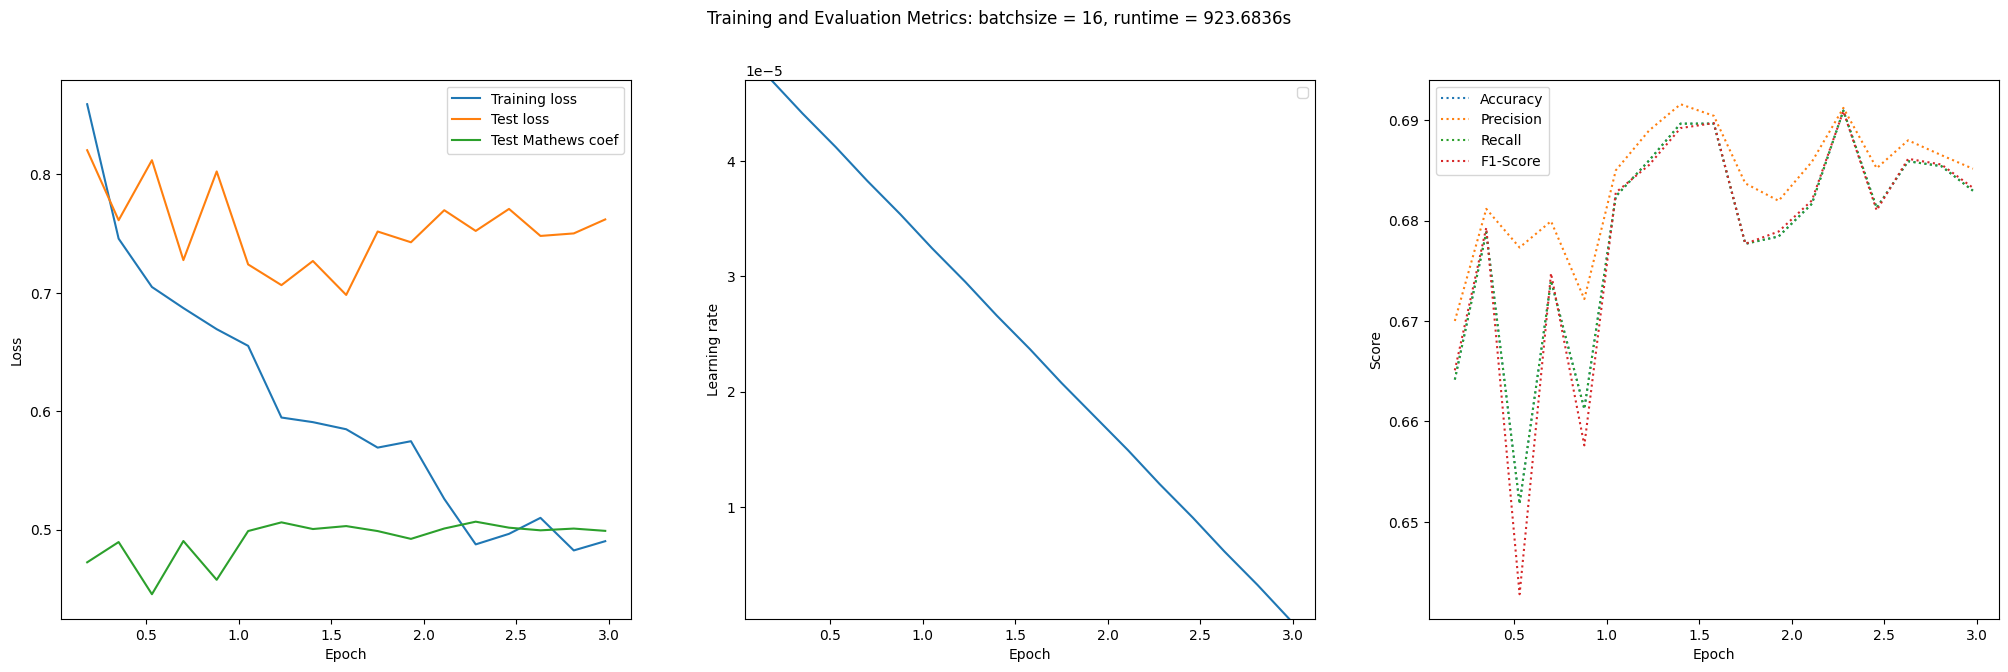

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6572959423065186,
 'eval_accuracy': 0.734,
 'eval_precision': 0.7336798903418614,
 'eval_recall': 0.734,
 'eval_f1': 0.7338303568180277,
 'eval_mathews': 0.5699678983234799,
 'eval_runtime': 3.6643,
 'eval_samples_per_second': 545.802,
 'eval_steps_per_second': 68.225,
 'epoch': 3.0}

In [15]:
tb1 = TestBench1(per_device_train_batch_size=16)
report(tb1, 16)
tb1.trainer.evaluate(val_dataset)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/4275 [00:00<?, ?it/s]

{'loss': 0.8292, 'learning_rate': 4.4152046783625734e-05, 'epoch': 0.35}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7702722549438477, 'eval_accuracy': 0.6769543973941368, 'eval_precision': 0.6820499391479623, 'eval_recall': 0.6769543973941368, 'eval_f1': 0.6773531755134816, 'eval_mathews': 0.487694315851867, 'eval_runtime': 21.6849, 'eval_samples_per_second': 566.477, 'eval_steps_per_second': 70.833, 'epoch': 0.35}
{'loss': 0.7013, 'learning_rate': 3.8304093567251465e-05, 'epoch': 0.7}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7407961487770081, 'eval_accuracy': 0.675814332247557, 'eval_precision': 0.6829345595469235, 'eval_recall': 0.675814332247557, 'eval_f1': 0.6746734083396908, 'eval_mathews': 0.480327175852345, 'eval_runtime': 21.6715, 'eval_samples_per_second': 566.827, 'eval_steps_per_second': 70.876, 'epoch': 0.7}
{'loss': 0.6645, 'learning_rate': 3.24561403508772e-05, 'epoch': 1.05}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7208732962608337, 'eval_accuracy': 0.6912866449511401, 'eval_precision': 0.6963505018659596, 'eval_recall': 0.6912866449511401, 'eval_f1': 0.6896876634075427, 'eval_mathews': 0.5019181706272489, 'eval_runtime': 21.7388, 'eval_samples_per_second': 565.072, 'eval_steps_per_second': 70.657, 'epoch': 1.05}
{'loss': 0.6038, 'learning_rate': 2.6608187134502928e-05, 'epoch': 1.4}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7110153436660767, 'eval_accuracy': 0.6908794788273616, 'eval_precision': 0.6927472466120697, 'eval_recall': 0.6908794788273616, 'eval_f1': 0.6908962360768989, 'eval_mathews': 0.5049251010664634, 'eval_runtime': 21.6504, 'eval_samples_per_second': 567.379, 'eval_steps_per_second': 70.945, 'epoch': 1.4}
{'loss': 0.5915, 'learning_rate': 2.0760233918128656e-05, 'epoch': 1.75}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7209125757217407, 'eval_accuracy': 0.6918566775244299, 'eval_precision': 0.6957370843515804, 'eval_recall': 0.6918566775244299, 'eval_f1': 0.6924206716576319, 'eval_mathews': 0.5116930354341996, 'eval_runtime': 21.895, 'eval_samples_per_second': 561.042, 'eval_steps_per_second': 70.153, 'epoch': 1.75}
{'loss': 0.5667, 'learning_rate': 1.4912280701754386e-05, 'epoch': 2.11}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7471054792404175, 'eval_accuracy': 0.6815960912052117, 'eval_precision': 0.6890775263609931, 'eval_recall': 0.6815960912052117, 'eval_f1': 0.6815470823181009, 'eval_mathews': 0.5071414416753375, 'eval_runtime': 21.5514, 'eval_samples_per_second': 569.985, 'eval_steps_per_second': 71.271, 'epoch': 2.11}
{'loss': 0.5108, 'learning_rate': 9.064327485380117e-06, 'epoch': 2.46}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7398739457130432, 'eval_accuracy': 0.6909609120521173, 'eval_precision': 0.6942682886709679, 'eval_recall': 0.6909609120521173, 'eval_f1': 0.6909297711904125, 'eval_mathews': 0.5152557946435328, 'eval_runtime': 21.6393, 'eval_samples_per_second': 567.67, 'eval_steps_per_second': 70.982, 'epoch': 2.46}
{'loss': 0.523, 'learning_rate': 3.216374269005848e-06, 'epoch': 2.81}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7196314334869385, 'eval_accuracy': 0.6932410423452768, 'eval_precision': 0.6942540977861519, 'eval_recall': 0.6932410423452768, 'eval_f1': 0.6933317481355873, 'eval_mathews': 0.5134593746655591, 'eval_runtime': 21.5007, 'eval_samples_per_second': 571.329, 'eval_steps_per_second': 71.439, 'epoch': 2.81}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'train_runtime': 532.4834, 'train_samples_per_second': 256.994, 'train_steps_per_second': 8.028, 'train_loss': 0.6173598475762975, 'epoch': 3.0}


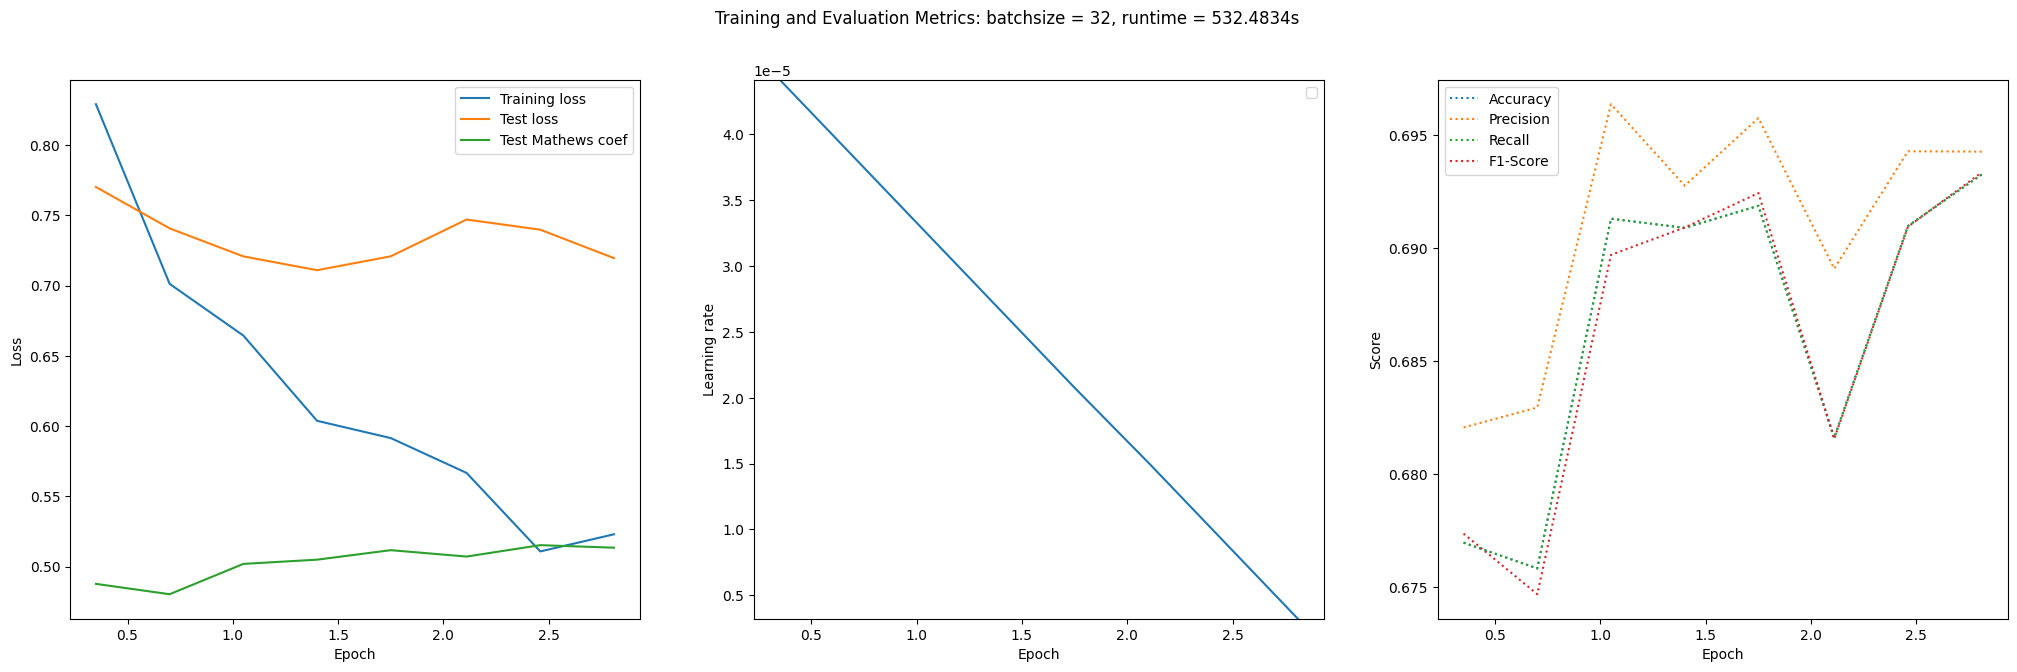

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.647361159324646,
 'eval_accuracy': 0.724,
 'eval_precision': 0.7258449815214465,
 'eval_recall': 0.724,
 'eval_f1': 0.72472548187957,
 'eval_mathews': 0.5568398582724798,
 'eval_runtime': 3.6682,
 'eval_samples_per_second': 545.229,
 'eval_steps_per_second': 68.154,
 'epoch': 3.0}

In [16]:
tb2 = TestBench1(per_device_train_batch_size=32, num_train_epochs=3)
report(tb2, 32)
tb2.trainer.evaluate(val_dataset)


Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/2136 [00:00<?, ?it/s]

{'loss': 0.7851, 'learning_rate': 3.829588014981274e-05, 'epoch': 0.7}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.741131067276001, 'eval_accuracy': 0.6748371335504886, 'eval_precision': 0.6811654763624494, 'eval_recall': 0.6748371335504886, 'eval_f1': 0.6756004346597784, 'eval_mathews': 0.4922941751493108, 'eval_runtime': 21.5954, 'eval_samples_per_second': 568.824, 'eval_steps_per_second': 71.126, 'epoch': 0.7}
{'loss': 0.6448, 'learning_rate': 2.6591760299625466e-05, 'epoch': 1.4}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.6887938380241394, 'eval_accuracy': 0.6870521172638436, 'eval_precision': 0.6895217549027647, 'eval_recall': 0.6870521172638436, 'eval_f1': 0.6864162150767367, 'eval_mathews': 0.5060312542770994, 'eval_runtime': 21.4121, 'eval_samples_per_second': 573.695, 'eval_steps_per_second': 71.735, 'epoch': 1.4}
{'loss': 0.5981, 'learning_rate': 1.4887640449438203e-05, 'epoch': 2.11}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7205434441566467, 'eval_accuracy': 0.6850162866449512, 'eval_precision': 0.6907980726077926, 'eval_recall': 0.6850162866449512, 'eval_f1': 0.684651734343544, 'eval_mathews': 0.5106705325258369, 'eval_runtime': 21.375, 'eval_samples_per_second': 574.69, 'eval_steps_per_second': 71.86, 'epoch': 2.11}
{'loss': 0.5508, 'learning_rate': 3.1835205992509364e-06, 'epoch': 2.81}


  0%|          | 0/1535 [00:00<?, ?it/s]

{'eval_loss': 0.7060566544532776, 'eval_accuracy': 0.6935667752442997, 'eval_precision': 0.6954847479848629, 'eval_recall': 0.6935667752442997, 'eval_f1': 0.6934795821668664, 'eval_mathews': 0.5166445888355706, 'eval_runtime': 21.5115, 'eval_samples_per_second': 571.043, 'eval_steps_per_second': 71.404, 'epoch': 2.81}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'train_runtime': 370.3255, 'train_samples_per_second': 369.526, 'train_steps_per_second': 5.768, 'train_loss': 0.6385952845941322, 'epoch': 3.0}


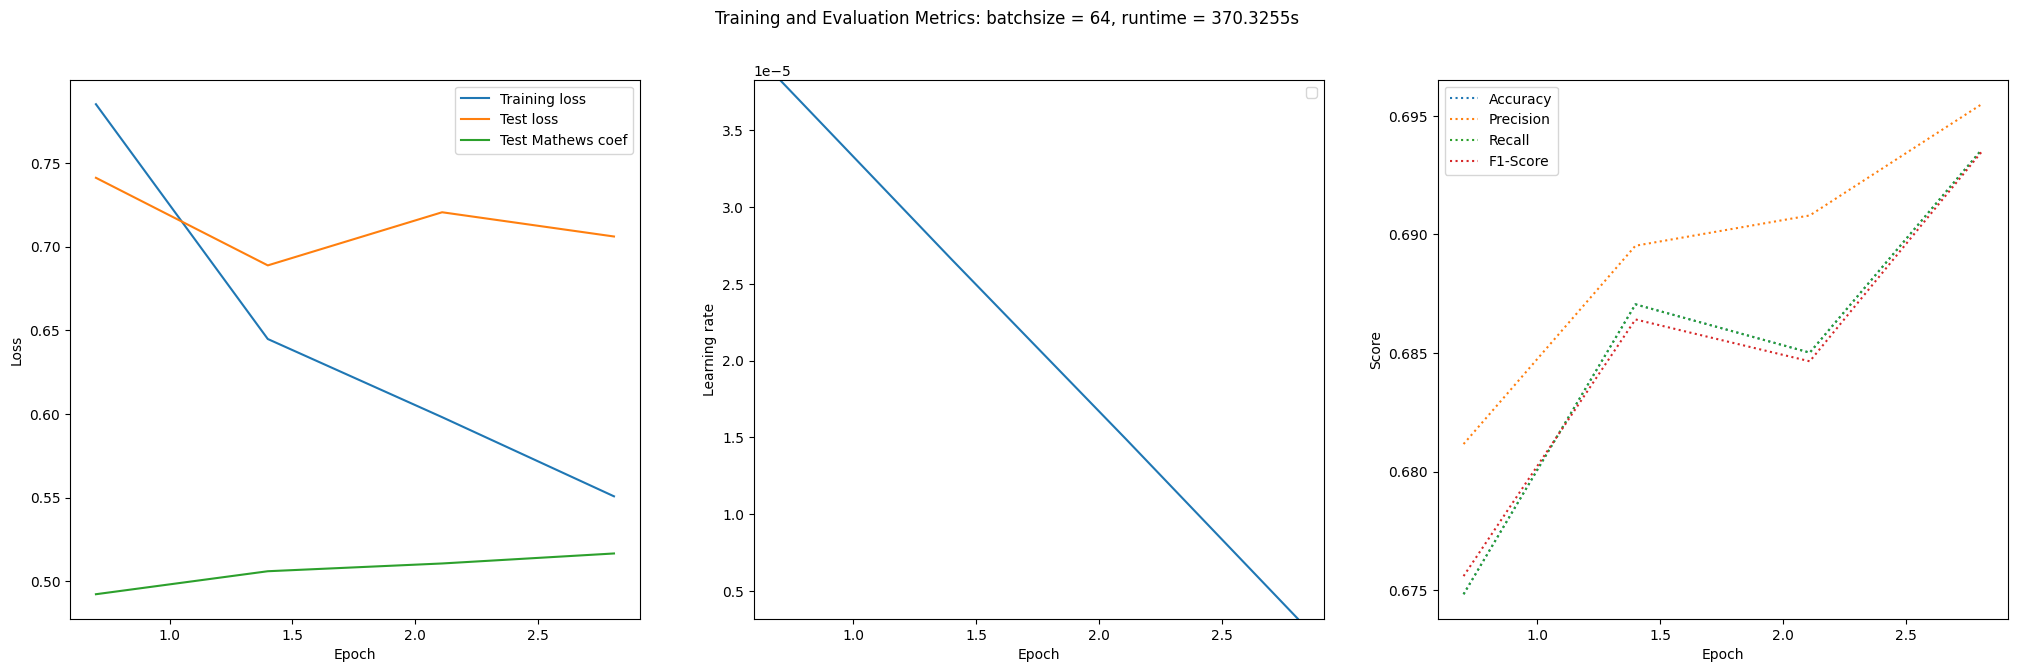

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6390350461006165,
 'eval_accuracy': 0.7255,
 'eval_precision': 0.7270106459776493,
 'eval_recall': 0.7255,
 'eval_f1': 0.7260160736070572,
 'eval_mathews': 0.5595391589555228,
 'eval_runtime': 3.6541,
 'eval_samples_per_second': 547.332,
 'eval_steps_per_second': 68.416,
 'epoch': 3.0}

In [17]:
tb3 = TestBench1(per_device_train_batch_size=64, num_train_epochs=3)
report(tb3, 64)
tb3.trainer.evaluate(val_dataset)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

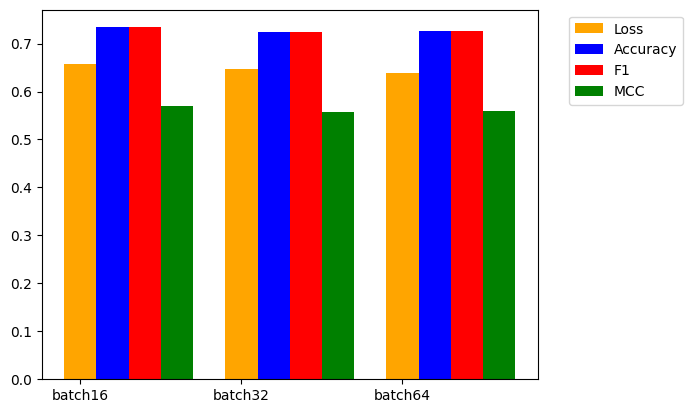

In [81]:
trs = {'batch16':tb1, 'batch32':tb2, 'batch64':tb3}
reportFinal(trs)

Dropout is a technique where randomly selected neurons in a layer are ignored during training. The idea is that this prevents the network from relying too heavily on any one feature, and encourages the network to learn more robust features that are useful in different contexts. Dropout can be added as a hyperparameter to the network, where a value between 0 and 1 is chosen to represent the fraction of neurons that are randomly dropped out.

Weight decay, on the other hand, is a technique where a penalty term is added to the loss function that the network is trying to minimize. This penalty term is proportional to the square of the magnitude of the weights in the network, and serves to discourage the weights from getting too large. By penalizing large weights, the network is encouraged to learn simpler functions that generalize better to new data. Weight decay is controlled by a hyperparameter called the weight decay rate, which determines the strength of the penalty. A higher weight decay rate will lead to more aggressive weight decay and vice versa.





In [87]:
class TestBench2():

    def __init__(self, per_device_train_batch_size, weight_decay, epochs=6):
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = ElectraForSequenceClassification.from_pretrained("google/electra-small-discriminator", num_labels = 3)
        model.to(device)
                
        training_args = TrainingArguments(
            output_dir="./models/model_electra",
            num_train_epochs=epochs,
            per_device_train_batch_size=per_device_train_batch_size,
            weight_decay=weight_decay,
            evaluation_strategy="steps",
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1",
            greater_is_better=True,
        )
        self.num_train_epochs = epochs
        self.per_device_train_batch_size = per_device_train_batch_size


        self.trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )
        # Train the model
        self.trainer.train()

def report(tb, batchsize, weight_decay):

    # Get the training logs
    logs = tb.trainer.state.log_history
    final_time = -1
    ymin = 999
    ymax = -999
    # Extract the loss values for each epoch
    train_history, test_history, lr_history, mcc_history, accuracy_history, precision_history,recall_history, f1_history = {},{},{},{},{},{},{},{}
    for log in logs:
        if log.get('loss'):
            train_history[log.get('epoch')] = log.get('loss')
        if log.get('eval_loss'):
            test_history[log.get('epoch')] = log.get('eval_loss')
        if log.get('learning_rate'):
            lr = log.get('learning_rate')
            lr_history[log.get('epoch')] = lr
            if lr > ymax: ymax = lr
            if lr < ymin: ymin = lr
        if log.get('train_runtime'):
            final_time = log.get('train_runtime')
        if log.get('eval_mathews'):
            mcc_history[log.get('epoch')] = log.get('eval_mathews')
        if log.get('eval_accuracy'):
            accuracy_history[log.get('epoch')] = log.get('eval_accuracy')
        if log.get('eval_precision'):
            precision_history[log.get('epoch')] = log.get('eval_precision')
        if log.get('eval_recall'):
            recall_history[log.get('epoch')] = log.get('eval_recall')
        if log.get('eval_f1'):
            f1_history[log.get('epoch')] = log.get('eval_f1')

    # Plot the loss curves and learning rates
    fig, axs = plt.subplots(1, 2, figsize = (16, 8))
    axs[0].plot(train_history.keys(), train_history.values(), label='Training loss')
    axs[0].plot(test_history.keys(), test_history.values(), label='Test loss')
    axs[0].plot(mcc_history.keys(), mcc_history.values(), label='Test Mathews coef')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(accuracy_history.keys(), accuracy_history.values(), label='Accuracy', linestyle=':')
    axs[1].plot(precision_history.keys(), precision_history.values(), label='Precision', linestyle=':')
    axs[1].plot(recall_history.keys(), recall_history.values(), label='Recall',linestyle=':')
    axs[1].plot(f1_history.keys(), f1_history.values(), label='F1-Score',linestyle=':')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Score')
    
    axs[1].legend()

    fig.suptitle(f'Training and Evaluation Metrics: batchsize = {batchsize}, runtime = {final_time}s, weight decay = {weight_decay}')

    plt.show()

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/8556 [00:00<?, ?it/s]

{'loss': 0.8217, 'learning_rate': 4.707807386629266e-05, 'epoch': 0.35}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7395141124725342, 'eval_accuracy': 0.6847932269619017, 'eval_precision': 0.685640135518955, 'eval_recall': 0.6847932269619017, 'eval_f1': 0.6850126228327461, 'eval_mathews': 0.4985797724701873, 'eval_runtime': 25.6245, 'eval_samples_per_second': 479.385, 'eval_steps_per_second': 59.943, 'epoch': 0.35}
{'loss': 0.6997, 'learning_rate': 4.415614773258532e-05, 'epoch': 0.7}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7103994488716125, 'eval_accuracy': 0.6872354281992836, 'eval_precision': 0.688411704046739, 'eval_recall': 0.6872354281992836, 'eval_f1': 0.6869715264554593, 'eval_mathews': 0.4973926414147135, 'eval_runtime': 25.6194, 'eval_samples_per_second': 479.481, 'eval_steps_per_second': 59.955, 'epoch': 0.7}
{'loss': 0.6645, 'learning_rate': 4.123422159887798e-05, 'epoch': 1.05}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7350459694862366, 'eval_accuracy': 0.6882937154021491, 'eval_precision': 0.6968361375018335, 'eval_recall': 0.6882937154021491, 'eval_f1': 0.6859948586813459, 'eval_mathews': 0.4978288851690628, 'eval_runtime': 25.7064, 'eval_samples_per_second': 477.857, 'eval_steps_per_second': 59.752, 'epoch': 1.05}
{'loss': 0.6011, 'learning_rate': 3.831229546517064e-05, 'epoch': 1.4}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7025424242019653, 'eval_accuracy': 0.6914685770107457, 'eval_precision': 0.6926476007791356, 'eval_recall': 0.6914685770107457, 'eval_f1': 0.6916368726724125, 'eval_mathews': 0.5107458079519447, 'eval_runtime': 25.4296, 'eval_samples_per_second': 483.059, 'eval_steps_per_second': 60.402, 'epoch': 1.4}
{'loss': 0.592, 'learning_rate': 3.53903693314633e-05, 'epoch': 1.75}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7221555709838867, 'eval_accuracy': 0.6865027678280691, 'eval_precision': 0.6902868945904732, 'eval_recall': 0.6865027678280691, 'eval_f1': 0.6870333909731102, 'eval_mathews': 0.5048931292493835, 'eval_runtime': 25.8228, 'eval_samples_per_second': 475.704, 'eval_steps_per_second': 59.482, 'epoch': 1.75}
{'loss': 0.5689, 'learning_rate': 3.246844319775596e-05, 'epoch': 2.1}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7810394763946533, 'eval_accuracy': 0.6723380006512537, 'eval_precision': 0.6799100405611354, 'eval_recall': 0.6723380006512537, 'eval_f1': 0.6725999423632528, 'eval_mathews': 0.49191958218222875, 'eval_runtime': 25.6812, 'eval_samples_per_second': 478.327, 'eval_steps_per_second': 59.81, 'epoch': 2.1}
{'loss': 0.5004, 'learning_rate': 2.9546517064048622e-05, 'epoch': 2.45}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7890510559082031, 'eval_accuracy': 0.6795017909475741, 'eval_precision': 0.6867946383197229, 'eval_recall': 0.6795017909475741, 'eval_f1': 0.6796292146050639, 'eval_mathews': 0.5031993499656884, 'eval_runtime': 25.8519, 'eval_samples_per_second': 475.169, 'eval_steps_per_second': 59.415, 'epoch': 2.45}
{'loss': 0.5215, 'learning_rate': 2.6624590930341282e-05, 'epoch': 2.81}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7699793577194214, 'eval_accuracy': 0.6770595897101921, 'eval_precision': 0.6862368558019798, 'eval_recall': 0.6770595897101921, 'eval_f1': 0.6757277600870945, 'eval_mathews': 0.4848408486250666, 'eval_runtime': 25.6525, 'eval_samples_per_second': 478.861, 'eval_steps_per_second': 59.877, 'epoch': 2.81}
{'loss': 0.4761, 'learning_rate': 2.3702664796633942e-05, 'epoch': 3.16}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.830011248588562, 'eval_accuracy': 0.6851188537935526, 'eval_precision': 0.6869720551765925, 'eval_recall': 0.6851188537935526, 'eval_f1': 0.6851330499851401, 'eval_mathews': 0.5029345499606681, 'eval_runtime': 27.3578, 'eval_samples_per_second': 449.012, 'eval_steps_per_second': 56.145, 'epoch': 3.16}
{'loss': 0.4385, 'learning_rate': 2.0780738662926602e-05, 'epoch': 3.51}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8274528980255127, 'eval_accuracy': 0.678606317160534, 'eval_precision': 0.6850306884963986, 'eval_recall': 0.678606317160534, 'eval_f1': 0.6781859231945115, 'eval_mathews': 0.5018352692936227, 'eval_runtime': 25.5579, 'eval_samples_per_second': 480.635, 'eval_steps_per_second': 60.099, 'epoch': 3.51}
{'loss': 0.4379, 'learning_rate': 1.7858812529219262e-05, 'epoch': 3.86}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8032343983650208, 'eval_accuracy': 0.6866655812438945, 'eval_precision': 0.6870696525175077, 'eval_recall': 0.6866655812438945, 'eval_f1': 0.6867808366869506, 'eval_mathews': 0.500276652740858, 'eval_runtime': 25.4969, 'eval_samples_per_second': 481.785, 'eval_steps_per_second': 60.243, 'epoch': 3.86}
{'loss': 0.3954, 'learning_rate': 1.4936886395511924e-05, 'epoch': 4.21}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.9141392111778259, 'eval_accuracy': 0.6681048518397916, 'eval_precision': 0.6776607194721103, 'eval_recall': 0.6681048518397916, 'eval_f1': 0.6691260262909202, 'eval_mathews': 0.48169640722906243, 'eval_runtime': 25.4526, 'eval_samples_per_second': 482.622, 'eval_steps_per_second': 60.347, 'epoch': 4.21}
{'loss': 0.3764, 'learning_rate': 1.2014960261804582e-05, 'epoch': 4.56}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8889763355255127, 'eval_accuracy': 0.6724194073591664, 'eval_precision': 0.6767872010692679, 'eval_recall': 0.6724194073591664, 'eval_f1': 0.6724205832712076, 'eval_mathews': 0.4881121655709125, 'eval_runtime': 25.49, 'eval_samples_per_second': 481.914, 'eval_steps_per_second': 60.259, 'epoch': 4.56}
{'loss': 0.3762, 'learning_rate': 9.093034128097242e-06, 'epoch': 4.91}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8862885236740112, 'eval_accuracy': 0.6731520677303809, 'eval_precision': 0.6771278159450808, 'eval_recall': 0.6731520677303809, 'eval_f1': 0.6733537736811169, 'eval_mathews': 0.487897708495927, 'eval_runtime': 25.5827, 'eval_samples_per_second': 480.168, 'eval_steps_per_second': 60.04, 'epoch': 4.91}
{'loss': 0.3422, 'learning_rate': 6.171107994389902e-06, 'epoch': 5.26}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.9323177337646484, 'eval_accuracy': 0.6790133507000977, 'eval_precision': 0.6812404048631642, 'eval_recall': 0.6790133507000977, 'eval_f1': 0.6792769684900243, 'eval_mathews': 0.49325328531932877, 'eval_runtime': 25.4827, 'eval_samples_per_second': 482.053, 'eval_steps_per_second': 60.276, 'epoch': 5.26}
{'loss': 0.3263, 'learning_rate': 3.2491818606825616e-06, 'epoch': 5.61}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.9336786270141602, 'eval_accuracy': 0.6818625854770433, 'eval_precision': 0.6823337667591926, 'eval_recall': 0.6818625854770433, 'eval_f1': 0.6820158082547015, 'eval_mathews': 0.4923129200861246, 'eval_runtime': 25.5661, 'eval_samples_per_second': 480.481, 'eval_steps_per_second': 60.08, 'epoch': 5.61}
{'loss': 0.3299, 'learning_rate': 3.272557269752221e-07, 'epoch': 5.96}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.9435946345329285, 'eval_accuracy': 0.6762455226310649, 'eval_precision': 0.6787326595747055, 'eval_recall': 0.6762455226310649, 'eval_f1': 0.67656672509113, 'eval_mathews': 0.48899312740438194, 'eval_runtime': 25.427, 'eval_samples_per_second': 483.108, 'eval_steps_per_second': 60.408, 'epoch': 5.96}
{'train_runtime': 1263.2489, 'train_samples_per_second': 216.656, 'train_steps_per_second': 6.773, 'train_loss': 0.4971024157455894, 'epoch': 6.0}


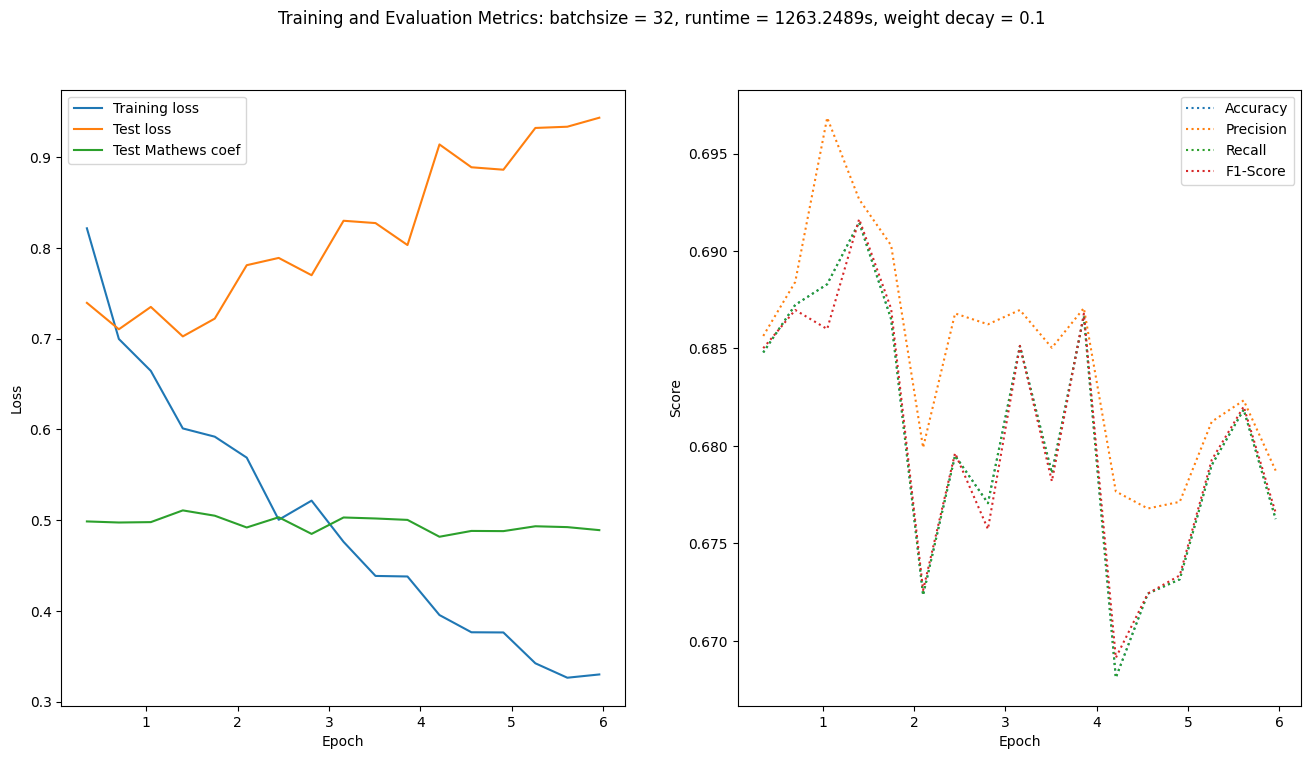

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6348018646240234,
 'eval_accuracy': 0.729,
 'eval_precision': 0.7305513265994,
 'eval_recall': 0.729,
 'eval_f1': 0.7296315080340626,
 'eval_mathews': 0.5643249159510227,
 'eval_runtime': 4.3619,
 'eval_samples_per_second': 458.515,
 'eval_steps_per_second': 57.314,
 'epoch': 6.0}

In [62]:
#d default default and elipsis
#tbA = TestBench2(32,0.1)
report(tbA, 32, weight_decay=0.1)
tbA.trainer.evaluate(val_dataset)

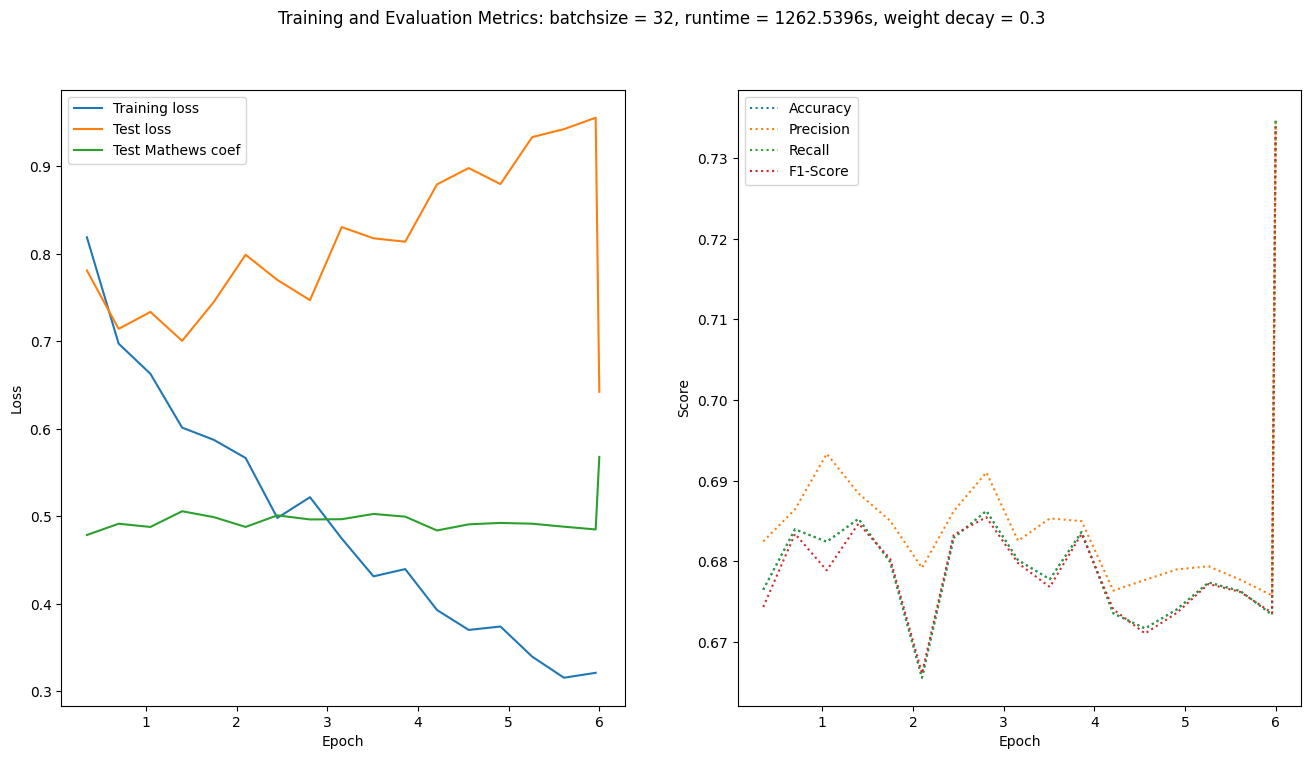

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6422461867332458,
 'eval_accuracy': 0.735,
 'eval_precision': 0.7345384834734985,
 'eval_recall': 0.735,
 'eval_f1': 0.7339065186718003,
 'eval_mathews': 0.5679149925371578,
 'eval_runtime': 4.5425,
 'eval_samples_per_second': 440.283,
 'eval_steps_per_second': 55.035,
 'epoch': 6.0}

In [88]:
#d default default and elipsis
#tbB = TestBench2(32,0.3)
report(tbB, 32, weight_decay=0.3)
tbB.trainer.evaluate(val_dataset)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/4278 [00:00<?, ?it/s]

{'loss': 0.776, 'learning_rate': 4.415614773258532e-05, 'epoch': 0.7}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.725058376789093, 'eval_accuracy': 0.6769781830022794, 'eval_precision': 0.6834833334026567, 'eval_recall': 0.6769781830022794, 'eval_f1': 0.677456187156308, 'eval_mathews': 0.4971152914044493, 'eval_runtime': 26.0196, 'eval_samples_per_second': 472.106, 'eval_steps_per_second': 59.032, 'epoch': 0.7}
{'loss': 0.6399, 'learning_rate': 3.831229546517064e-05, 'epoch': 1.4}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.6926496624946594, 'eval_accuracy': 0.6920384239661348, 'eval_precision': 0.6920903713222812, 'eval_recall': 0.6920384239661348, 'eval_f1': 0.6920587458301287, 'eval_mathews': 0.5073128076433848, 'eval_runtime': 25.9162, 'eval_samples_per_second': 473.99, 'eval_steps_per_second': 59.268, 'epoch': 1.4}
{'loss': 0.594, 'learning_rate': 3.246844319775596e-05, 'epoch': 2.1}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7188107371330261, 'eval_accuracy': 0.6839791598827744, 'eval_precision': 0.688884804634499, 'eval_recall': 0.6839791598827744, 'eval_f1': 0.6843652383340026, 'eval_mathews': 0.5058354380725442, 'eval_runtime': 25.5085, 'eval_samples_per_second': 481.565, 'eval_steps_per_second': 60.215, 'epoch': 2.1}
{'loss': 0.5402, 'learning_rate': 2.6624590930341282e-05, 'epoch': 2.81}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.6910497546195984, 'eval_accuracy': 0.6970856398567242, 'eval_precision': 0.6970377877950247, 'eval_recall': 0.6970856398567242, 'eval_f1': 0.6970548526313417, 'eval_mathews': 0.5143950931013871, 'eval_runtime': 25.9017, 'eval_samples_per_second': 474.255, 'eval_steps_per_second': 59.301, 'epoch': 2.81}
{'loss': 0.4978, 'learning_rate': 2.0780738662926602e-05, 'epoch': 3.51}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7851102948188782, 'eval_accuracy': 0.6887007489417128, 'eval_precision': 0.6902911190526808, 'eval_recall': 0.6887007489417128, 'eval_f1': 0.6890281638770409, 'eval_mathews': 0.5064927069960631, 'eval_runtime': 25.962, 'eval_samples_per_second': 473.153, 'eval_steps_per_second': 59.163, 'epoch': 3.51}
{'loss': 0.4616, 'learning_rate': 1.4936886395511924e-05, 'epoch': 4.21}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7907461524009705, 'eval_accuracy': 0.6847118202539889, 'eval_precision': 0.6875169803038425, 'eval_recall': 0.6847118202539889, 'eval_f1': 0.6849415160737939, 'eval_mathews': 0.5037325026007997, 'eval_runtime': 26.2092, 'eval_samples_per_second': 468.691, 'eval_steps_per_second': 58.605, 'epoch': 4.21}
{'loss': 0.4319, 'learning_rate': 9.093034128097242e-06, 'epoch': 4.91}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8070576786994934, 'eval_accuracy': 0.6787691305763595, 'eval_precision': 0.684680729487279, 'eval_recall': 0.6787691305763595, 'eval_f1': 0.6782920424959437, 'eval_mathews': 0.5013288882157423, 'eval_runtime': 25.6289, 'eval_samples_per_second': 479.302, 'eval_steps_per_second': 59.932, 'epoch': 4.91}
{'loss': 0.3973, 'learning_rate': 3.2491818606825616e-06, 'epoch': 5.61}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8344321250915527, 'eval_accuracy': 0.6871540214913708, 'eval_precision': 0.6885490295659639, 'eval_recall': 0.6871540214913708, 'eval_f1': 0.6873746382638791, 'eval_mathews': 0.5042637342031171, 'eval_runtime': 25.7716, 'eval_samples_per_second': 476.648, 'eval_steps_per_second': 59.6, 'epoch': 5.61}
{'train_runtime': 829.4402, 'train_samples_per_second': 329.97, 'train_steps_per_second': 5.158, 'train_loss': 0.5329332445313185, 'epoch': 6.0}


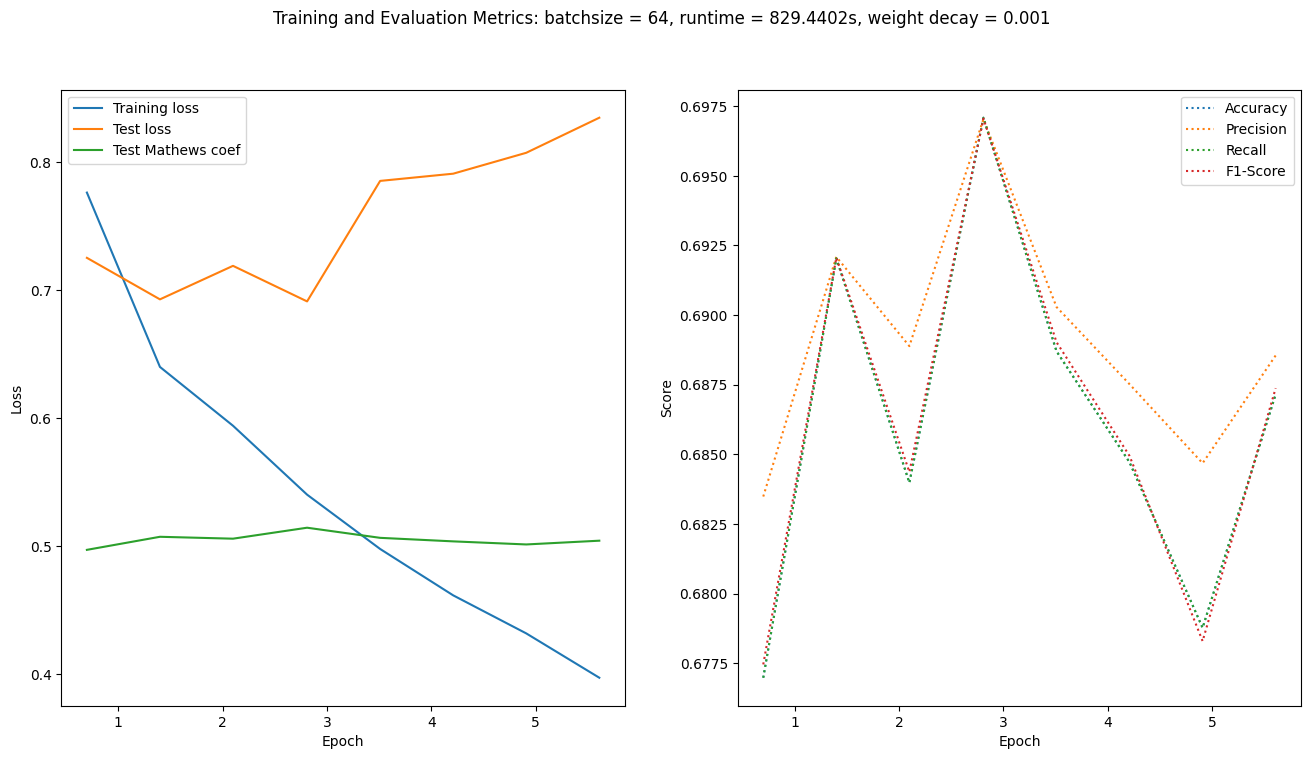

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6348741054534912,
 'eval_accuracy': 0.728,
 'eval_precision': 0.7323314907796296,
 'eval_recall': 0.728,
 'eval_f1': 0.729323145307978,
 'eval_mathews': 0.5641652699193627,
 'eval_runtime': 4.3543,
 'eval_samples_per_second': 459.312,
 'eval_steps_per_second': 57.414,
 'epoch': 6.0}

In [89]:
tbC = TestBench2(64,0.001)
report(tbC,64,weight_decay = 0.001)
tbC.trainer.evaluate(val_dataset)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/4278 [00:00<?, ?it/s]

{'loss': 0.7795, 'learning_rate': 4.415614773258532e-05, 'epoch': 0.7}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7416850924491882, 'eval_accuracy': 0.674373168349072, 'eval_precision': 0.6804937557587729, 'eval_recall': 0.674373168349072, 'eval_f1': 0.675254263605235, 'eval_mathews': 0.49015165257879567, 'eval_runtime': 25.8118, 'eval_samples_per_second': 475.906, 'eval_steps_per_second': 59.508, 'epoch': 0.7}
{'loss': 0.6373, 'learning_rate': 3.831229546517064e-05, 'epoch': 1.4}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.6993945837020874, 'eval_accuracy': 0.6869098013676327, 'eval_precision': 0.6872590302633518, 'eval_recall': 0.6869098013676327, 'eval_f1': 0.6868988375345592, 'eval_mathews': 0.5007891259056239, 'eval_runtime': 25.2143, 'eval_samples_per_second': 487.183, 'eval_steps_per_second': 60.918, 'epoch': 1.4}
{'loss': 0.592, 'learning_rate': 3.246844319775596e-05, 'epoch': 2.1}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7287464737892151, 'eval_accuracy': 0.6803972647346141, 'eval_precision': 0.6856321676606347, 'eval_recall': 0.6803972647346141, 'eval_f1': 0.6800432632254599, 'eval_mathews': 0.502578689184844, 'eval_runtime': 25.4382, 'eval_samples_per_second': 482.895, 'eval_steps_per_second': 60.382, 'epoch': 2.1}
{'loss': 0.5364, 'learning_rate': 2.6624590930341282e-05, 'epoch': 2.81}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7203196883201599, 'eval_accuracy': 0.6881309019863237, 'eval_precision': 0.6897327723655247, 'eval_recall': 0.6881309019863237, 'eval_f1': 0.6883115702182534, 'eval_mathews': 0.50653329757179, 'eval_runtime': 25.2299, 'eval_samples_per_second': 486.884, 'eval_steps_per_second': 60.88, 'epoch': 2.81}
{'loss': 0.495, 'learning_rate': 2.0780738662926602e-05, 'epoch': 3.51}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7864140272140503, 'eval_accuracy': 0.6844676001302508, 'eval_precision': 0.6860521987703214, 'eval_recall': 0.6844676001302508, 'eval_f1': 0.6842204298596002, 'eval_mathews': 0.5011615399182546, 'eval_runtime': 25.4579, 'eval_samples_per_second': 482.522, 'eval_steps_per_second': 60.335, 'epoch': 3.51}
{'loss': 0.4601, 'learning_rate': 1.4936886395511924e-05, 'epoch': 4.21}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8010677695274353, 'eval_accuracy': 0.6803972647346141, 'eval_precision': 0.6833520624820346, 'eval_recall': 0.6803972647346141, 'eval_f1': 0.6805263443173948, 'eval_mathews': 0.49764123143248384, 'eval_runtime': 26.8848, 'eval_samples_per_second': 456.912, 'eval_steps_per_second': 57.133, 'epoch': 4.21}
{'loss': 0.4277, 'learning_rate': 9.093034128097242e-06, 'epoch': 4.91}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8182303309440613, 'eval_accuracy': 0.6738847281015956, 'eval_precision': 0.6797857720923378, 'eval_recall': 0.6738847281015956, 'eval_f1': 0.6733232199200304, 'eval_mathews': 0.4939311772655913, 'eval_runtime': 26.0937, 'eval_samples_per_second': 470.765, 'eval_steps_per_second': 58.865, 'epoch': 4.91}
{'loss': 0.3923, 'learning_rate': 3.2491818606825616e-06, 'epoch': 5.61}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8578155636787415, 'eval_accuracy': 0.6781178769130576, 'eval_precision': 0.6797804718170827, 'eval_recall': 0.6781178769130576, 'eval_f1': 0.6783360925355927, 'eval_mathews': 0.4907321048850453, 'eval_runtime': 25.2697, 'eval_samples_per_second': 486.116, 'eval_steps_per_second': 60.784, 'epoch': 5.61}
{'train_runtime': 822.5302, 'train_samples_per_second': 332.742, 'train_steps_per_second': 5.201, 'train_loss': 0.5304055037817257, 'epoch': 6.0}


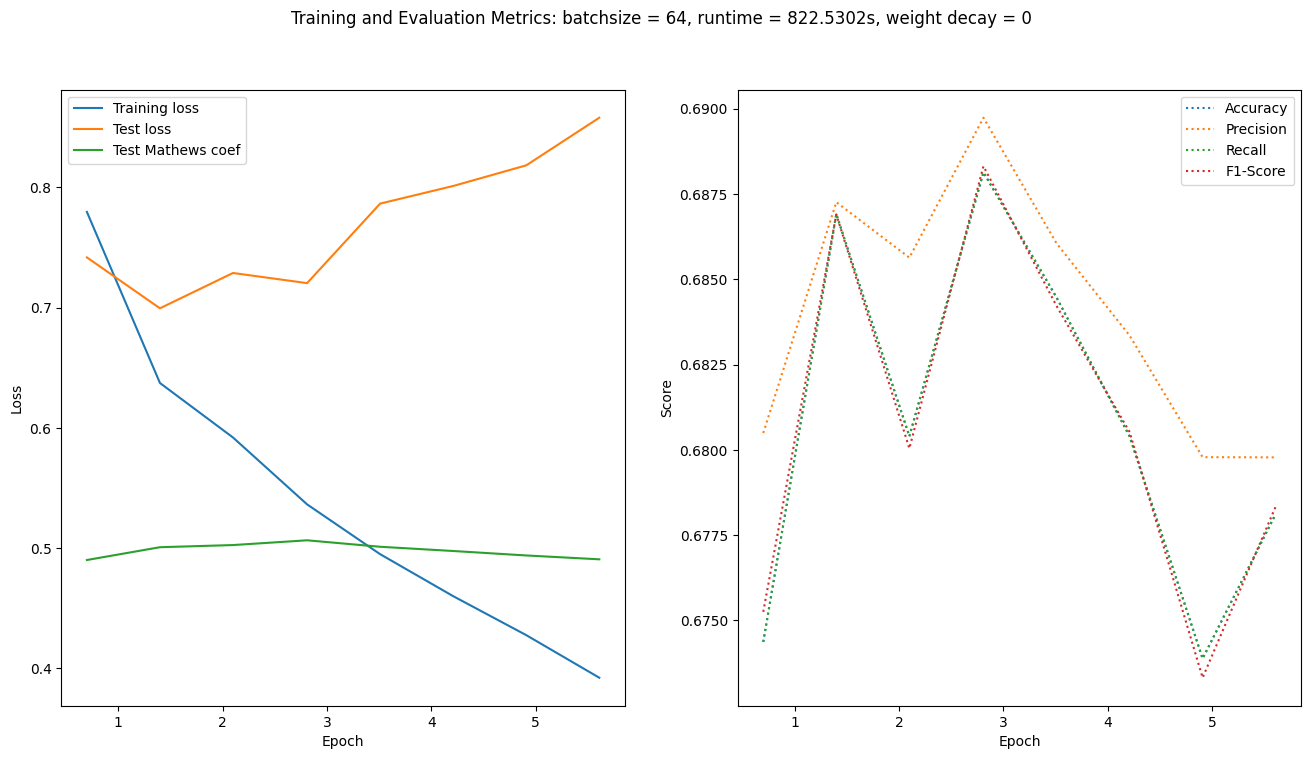

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6370247602462769,
 'eval_accuracy': 0.724,
 'eval_precision': 0.7256114750175534,
 'eval_recall': 0.724,
 'eval_f1': 0.7243552031448144,
 'eval_mathews': 0.558092073544847,
 'eval_runtime': 4.2496,
 'eval_samples_per_second': 470.631,
 'eval_steps_per_second': 58.829,
 'epoch': 6.0}

In [69]:
tbD = TestBench2(64,weight_decay=0)
report(tbD,64, weight_decay=0)
tbD.trainer.evaluate(val_dataset)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/8556 [00:00<?, ?it/s]

{'loss': 0.8181, 'learning_rate': 4.707807386629266e-05, 'epoch': 0.35}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7409055233001709, 'eval_accuracy': 0.6792575708238359, 'eval_precision': 0.6817190122834059, 'eval_recall': 0.6792575708238359, 'eval_f1': 0.6796704780848996, 'eval_mathews': 0.4928316489813166, 'eval_runtime': 25.7654, 'eval_samples_per_second': 476.764, 'eval_steps_per_second': 59.615, 'epoch': 0.35}
{'loss': 0.6979, 'learning_rate': 4.415614773258532e-05, 'epoch': 0.7}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7227896451950073, 'eval_accuracy': 0.6824324324324325, 'eval_precision': 0.6866864330082336, 'eval_recall': 0.6824324324324325, 'eval_f1': 0.6826622732633473, 'eval_mathews': 0.49434099490526434, 'eval_runtime': 25.868, 'eval_samples_per_second': 474.873, 'eval_steps_per_second': 59.378, 'epoch': 0.7}
{'loss': 0.667, 'learning_rate': 4.123422159887798e-05, 'epoch': 1.05}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7492175698280334, 'eval_accuracy': 0.6759198957994139, 'eval_precision': 0.6899425944960976, 'eval_recall': 0.6759198957994139, 'eval_f1': 0.6706520758192673, 'eval_mathews': 0.4772869077718544, 'eval_runtime': 25.8501, 'eval_samples_per_second': 475.201, 'eval_steps_per_second': 59.419, 'epoch': 1.05}
{'loss': 0.6023, 'learning_rate': 3.831229546517064e-05, 'epoch': 1.4}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.6888236403465271, 'eval_accuracy': 0.6904916965157929, 'eval_precision': 0.6911102529936733, 'eval_recall': 0.6904916965157929, 'eval_f1': 0.690415451519724, 'eval_mathews': 0.5078495327391961, 'eval_runtime': 25.8704, 'eval_samples_per_second': 474.829, 'eval_steps_per_second': 59.373, 'epoch': 1.4}
{'loss': 0.5915, 'learning_rate': 3.53903693314633e-05, 'epoch': 1.75}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7122096419334412, 'eval_accuracy': 0.6911429501790948, 'eval_precision': 0.6934096397394159, 'eval_recall': 0.6911429501790948, 'eval_f1': 0.6915822225470526, 'eval_mathews': 0.5105860463714611, 'eval_runtime': 25.7955, 'eval_samples_per_second': 476.207, 'eval_steps_per_second': 59.545, 'epoch': 1.75}
{'loss': 0.5743, 'learning_rate': 3.246844319775596e-05, 'epoch': 2.1}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7956668734550476, 'eval_accuracy': 0.6684304786714426, 'eval_precision': 0.6787061564808552, 'eval_recall': 0.6684304786714426, 'eval_f1': 0.6689241950868094, 'eval_mathews': 0.4882889876240044, 'eval_runtime': 25.7495, 'eval_samples_per_second': 477.059, 'eval_steps_per_second': 59.652, 'epoch': 2.1}
{'loss': 0.5038, 'learning_rate': 2.9546517064048622e-05, 'epoch': 2.45}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7631204724311829, 'eval_accuracy': 0.6824324324324325, 'eval_precision': 0.6862281158637589, 'eval_recall': 0.6824324324324325, 'eval_f1': 0.6825233384310053, 'eval_mathews': 0.5025037326638186, 'eval_runtime': 25.8174, 'eval_samples_per_second': 475.804, 'eval_steps_per_second': 59.495, 'epoch': 2.45}
{'loss': 0.527, 'learning_rate': 2.6624590930341282e-05, 'epoch': 2.81}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.725685715675354, 'eval_accuracy': 0.6854444806252035, 'eval_precision': 0.6892571679327931, 'eval_recall': 0.6854444806252035, 'eval_f1': 0.6851652534348565, 'eval_mathews': 0.4959281801273585, 'eval_runtime': 25.7391, 'eval_samples_per_second': 477.251, 'eval_steps_per_second': 59.676, 'epoch': 2.81}
{'loss': 0.4815, 'learning_rate': 2.3702664796633942e-05, 'epoch': 3.16}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.813758373260498, 'eval_accuracy': 0.6767339628785412, 'eval_precision': 0.6804413490473722, 'eval_recall': 0.6767339628785412, 'eval_f1': 0.6761262292979128, 'eval_mathews': 0.49431473050266916, 'eval_runtime': 25.7867, 'eval_samples_per_second': 476.369, 'eval_steps_per_second': 59.566, 'epoch': 3.16}
{'loss': 0.4487, 'learning_rate': 2.0780738662926602e-05, 'epoch': 3.51}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8223902583122253, 'eval_accuracy': 0.6734776945620319, 'eval_precision': 0.6787908554756782, 'eval_recall': 0.6734776945620319, 'eval_f1': 0.673659454322975, 'eval_mathews': 0.49074150987955634, 'eval_runtime': 25.7705, 'eval_samples_per_second': 476.669, 'eval_steps_per_second': 59.603, 'epoch': 3.51}
{'loss': 0.4431, 'learning_rate': 1.7858812529219262e-05, 'epoch': 3.86}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8204127550125122, 'eval_accuracy': 0.6856072940410289, 'eval_precision': 0.6856342556874537, 'eval_recall': 0.6856072940410289, 'eval_f1': 0.6855536352110535, 'eval_mathews': 0.4970374939794676, 'eval_runtime': 25.9064, 'eval_samples_per_second': 474.169, 'eval_steps_per_second': 59.29, 'epoch': 3.86}
{'loss': 0.4084, 'learning_rate': 1.4936886395511924e-05, 'epoch': 4.21}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8434284329414368, 'eval_accuracy': 0.6792575708238359, 'eval_precision': 0.6815877388962074, 'eval_recall': 0.6792575708238359, 'eval_f1': 0.6796068946283371, 'eval_mathews': 0.49319890173771147, 'eval_runtime': 25.7499, 'eval_samples_per_second': 477.05, 'eval_steps_per_second': 59.651, 'epoch': 4.21}
{'loss': 0.383, 'learning_rate': 1.2014960261804582e-05, 'epoch': 4.56}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8779013752937317, 'eval_accuracy': 0.6742917616411592, 'eval_precision': 0.6784270117991497, 'eval_recall': 0.6742917616411592, 'eval_f1': 0.6747567450647208, 'eval_mathews': 0.48876904502067836, 'eval_runtime': 25.7708, 'eval_samples_per_second': 476.664, 'eval_steps_per_second': 59.602, 'epoch': 4.56}
{'loss': 0.3879, 'learning_rate': 9.093034128097242e-06, 'epoch': 4.91}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8573171496391296, 'eval_accuracy': 0.6698957994138717, 'eval_precision': 0.6741839657928358, 'eval_recall': 0.6698957994138717, 'eval_f1': 0.6693923794033892, 'eval_mathews': 0.4846346474641169, 'eval_runtime': 25.7217, 'eval_samples_per_second': 477.573, 'eval_steps_per_second': 59.716, 'epoch': 4.91}
{'loss': 0.359, 'learning_rate': 6.171107994389902e-06, 'epoch': 5.26}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.9005398154258728, 'eval_accuracy': 0.6771409964181049, 'eval_precision': 0.678825534978427, 'eval_recall': 0.6771409964181049, 'eval_f1': 0.6774067142097633, 'eval_mathews': 0.48895500947040793, 'eval_runtime': 25.8413, 'eval_samples_per_second': 475.363, 'eval_steps_per_second': 59.44, 'epoch': 5.26}
{'loss': 0.3396, 'learning_rate': 3.2491818606825616e-06, 'epoch': 5.61}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.9180111885070801, 'eval_accuracy': 0.6796646043633996, 'eval_precision': 0.6806770310479531, 'eval_recall': 0.6796646043633996, 'eval_f1': 0.6799500636012124, 'eval_mathews': 0.4895206153639653, 'eval_runtime': 26.0826, 'eval_samples_per_second': 470.966, 'eval_steps_per_second': 58.89, 'epoch': 5.61}
{'loss': 0.3432, 'learning_rate': 3.272557269752221e-07, 'epoch': 5.96}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.9156726598739624, 'eval_accuracy': 0.6788505372842722, 'eval_precision': 0.6802741455633534, 'eval_recall': 0.6788505372842722, 'eval_f1': 0.6791146467344719, 'eval_mathews': 0.49089945554925807, 'eval_runtime': 25.8346, 'eval_samples_per_second': 475.486, 'eval_steps_per_second': 59.455, 'epoch': 5.96}
{'train_runtime': 1258.3561, 'train_samples_per_second': 217.498, 'train_steps_per_second': 6.799, 'train_loss': 0.5035254570745653, 'epoch': 6.0}


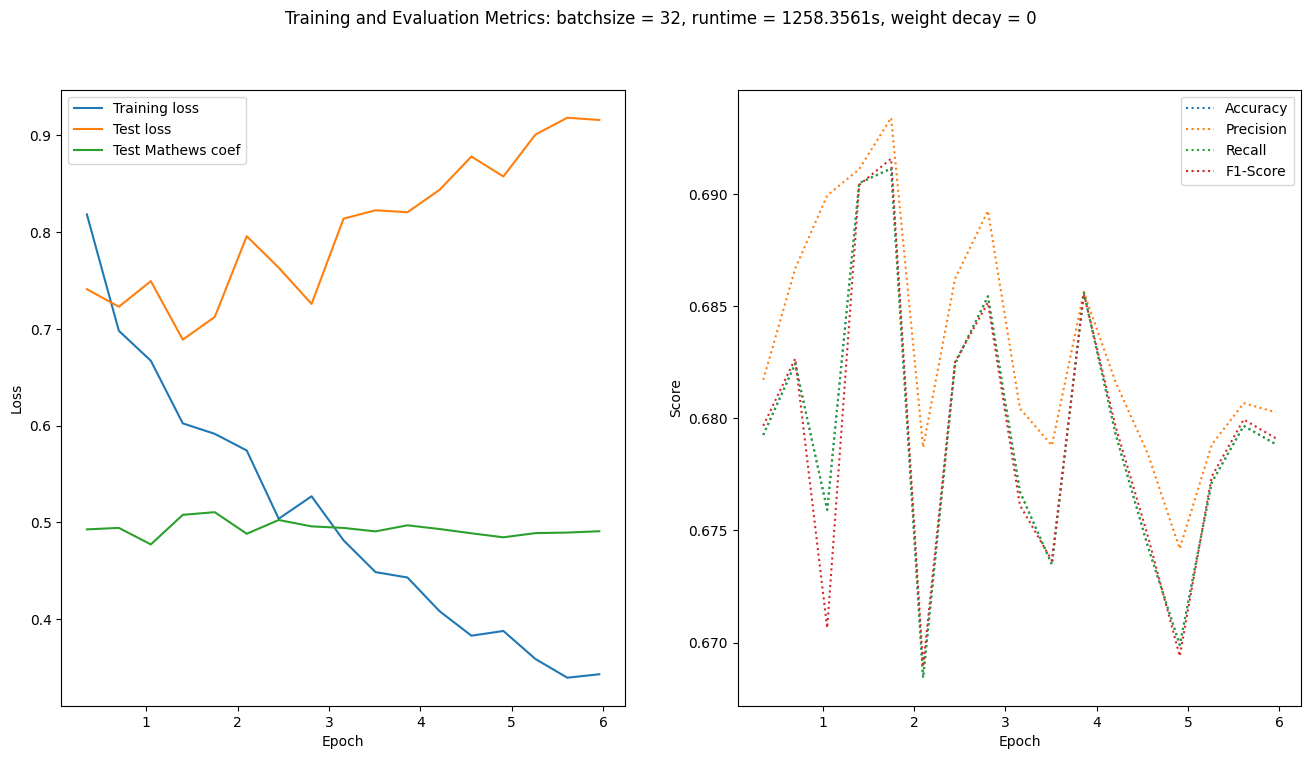

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.641190230846405,
 'eval_accuracy': 0.7315,
 'eval_precision': 0.7322277953687569,
 'eval_recall': 0.7315,
 'eval_f1': 0.7317842933006536,
 'eval_mathews': 0.5679150526420277,
 'eval_runtime': 4.3073,
 'eval_samples_per_second': 464.33,
 'eval_steps_per_second': 58.041,
 'epoch': 6.0}

In [91]:
tbE = TestBench2(32,0)
report(tbE,32, 0)
tbE.trainer.evaluate(val_dataset)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/2142 [00:00<?, ?it/s]

{'loss': 0.7338, 'learning_rate': 3.832866479925304e-05, 'epoch': 1.4}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.6866870522499084, 'eval_accuracy': 0.6922826440898731, 'eval_precision': 0.6953848812457526, 'eval_recall': 0.6922826440898731, 'eval_f1': 0.6915967956270087, 'eval_mathews': 0.5150574682197271, 'eval_runtime': 25.6091, 'eval_samples_per_second': 479.673, 'eval_steps_per_second': 59.979, 'epoch': 1.4}
{'loss': 0.588, 'learning_rate': 2.665732959850607e-05, 'epoch': 2.8}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.701418399810791, 'eval_accuracy': 0.6930967111690003, 'eval_precision': 0.6950362762315467, 'eval_recall': 0.6930967111690003, 'eval_f1': 0.6934202595037341, 'eval_mathews': 0.5136451029164009, 'eval_runtime': 27.0465, 'eval_samples_per_second': 454.18, 'eval_steps_per_second': 56.791, 'epoch': 2.8}
{'loss': 0.5182, 'learning_rate': 1.4985994397759103e-05, 'epoch': 4.2}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7746362090110779, 'eval_accuracy': 0.6714425268642136, 'eval_precision': 0.6851958615141408, 'eval_recall': 0.6714425268642136, 'eval_f1': 0.6696555514421381, 'eval_mathews': 0.5014208858591648, 'eval_runtime': 26.0676, 'eval_samples_per_second': 471.236, 'eval_steps_per_second': 58.924, 'epoch': 4.2}
{'loss': 0.4663, 'learning_rate': 3.3146591970121383e-06, 'epoch': 5.6}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7791665196418762, 'eval_accuracy': 0.681048518397916, 'eval_precision': 0.6866646629227287, 'eval_recall': 0.681048518397916, 'eval_f1': 0.6807366685645542, 'eval_mathews': 0.5040358704131143, 'eval_runtime': 26.0033, 'eval_samples_per_second': 472.401, 'eval_steps_per_second': 59.069, 'epoch': 5.6}
{'train_runtime': 622.1724, 'train_samples_per_second': 439.894, 'train_steps_per_second': 3.443, 'train_loss': 0.56840646211284, 'epoch': 6.0}


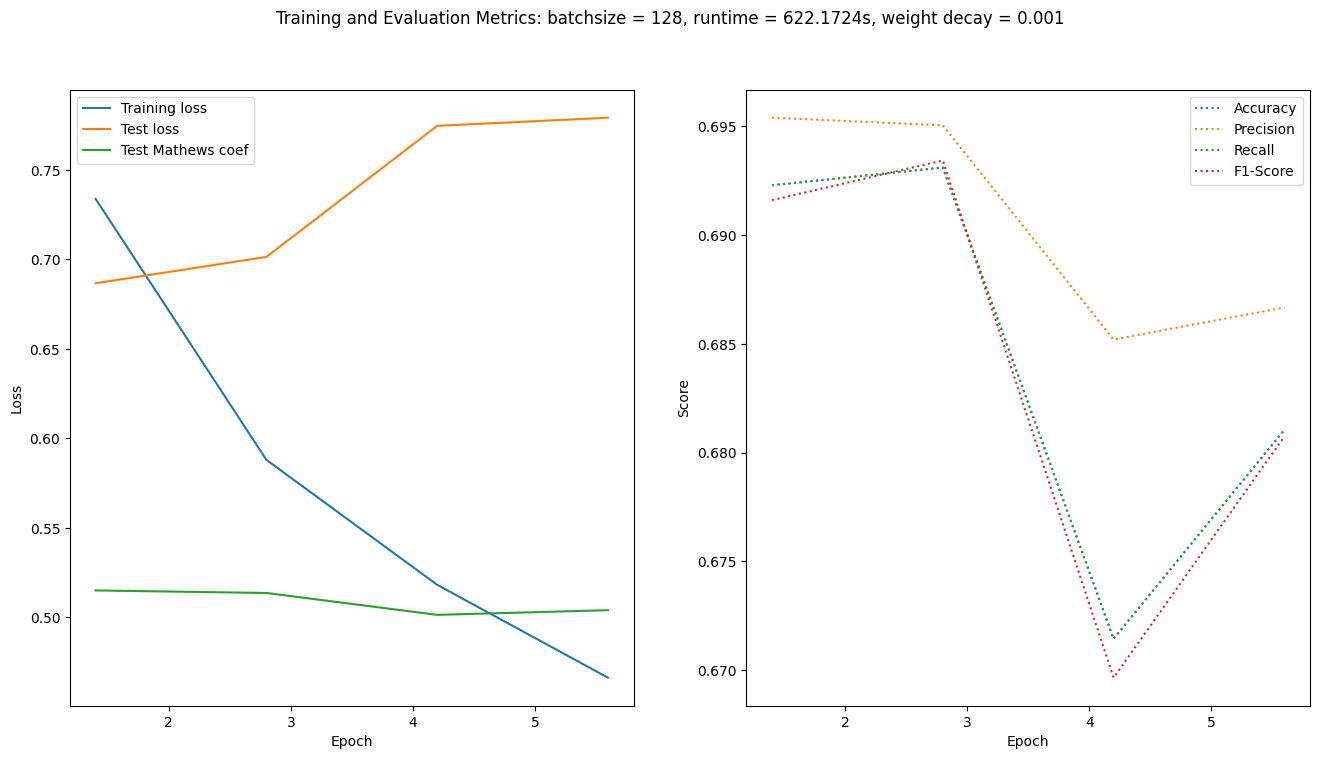

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6362370848655701,
 'eval_accuracy': 0.729,
 'eval_precision': 0.7293400029099201,
 'eval_recall': 0.729,
 'eval_f1': 0.7289925781220302,
 'eval_mathews': 0.5640863400698115,
 'eval_runtime': 4.3355,
 'eval_samples_per_second': 461.305,
 'eval_steps_per_second': 57.663,
 'epoch': 6.0}

In [ ]:
tbF = TestBench2(16,0.001)
report(tbF,16, weight_decay=0.001)
tbF.trainer.evaluate(val_dataset)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/2142 [00:00<?, ?it/s]

{'loss': 0.7338, 'learning_rate': 3.832866479925304e-05, 'epoch': 1.4}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.6866863369941711, 'eval_accuracy': 0.6922826440898731, 'eval_precision': 0.6953848812457526, 'eval_recall': 0.6922826440898731, 'eval_f1': 0.6915967956270087, 'eval_mathews': 0.5150574682197271, 'eval_runtime': 26.0335, 'eval_samples_per_second': 471.854, 'eval_steps_per_second': 59.001, 'epoch': 1.4}
{'loss': 0.588, 'learning_rate': 2.665732959850607e-05, 'epoch': 2.8}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7014383673667908, 'eval_accuracy': 0.6929338977531748, 'eval_precision': 0.6948800159410142, 'eval_recall': 0.6929338977531748, 'eval_f1': 0.6932610414908378, 'eval_mathews': 0.5133866458035974, 'eval_runtime': 25.8496, 'eval_samples_per_second': 475.211, 'eval_steps_per_second': 59.421, 'epoch': 2.8}
{'loss': 0.5182, 'learning_rate': 1.4985994397759103e-05, 'epoch': 4.2}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7745100855827332, 'eval_accuracy': 0.671605340280039, 'eval_precision': 0.685310668055959, 'eval_recall': 0.671605340280039, 'eval_f1': 0.6698217332943913, 'eval_mathews': 0.5016074344786409, 'eval_runtime': 25.2588, 'eval_samples_per_second': 486.325, 'eval_steps_per_second': 60.81, 'epoch': 4.2}
{'loss': 0.4663, 'learning_rate': 3.3146591970121383e-06, 'epoch': 5.6}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7791560888290405, 'eval_accuracy': 0.6807228915662651, 'eval_precision': 0.6863575479304111, 'eval_recall': 0.6807228915662651, 'eval_f1': 0.6804066274533693, 'eval_mathews': 0.5035657426261031, 'eval_runtime': 25.4015, 'eval_samples_per_second': 483.593, 'eval_steps_per_second': 60.469, 'epoch': 5.6}
{'train_runtime': 616.5961, 'train_samples_per_second': 443.872, 'train_steps_per_second': 3.474, 'train_loss': 0.5684076944986979, 'epoch': 6.0}


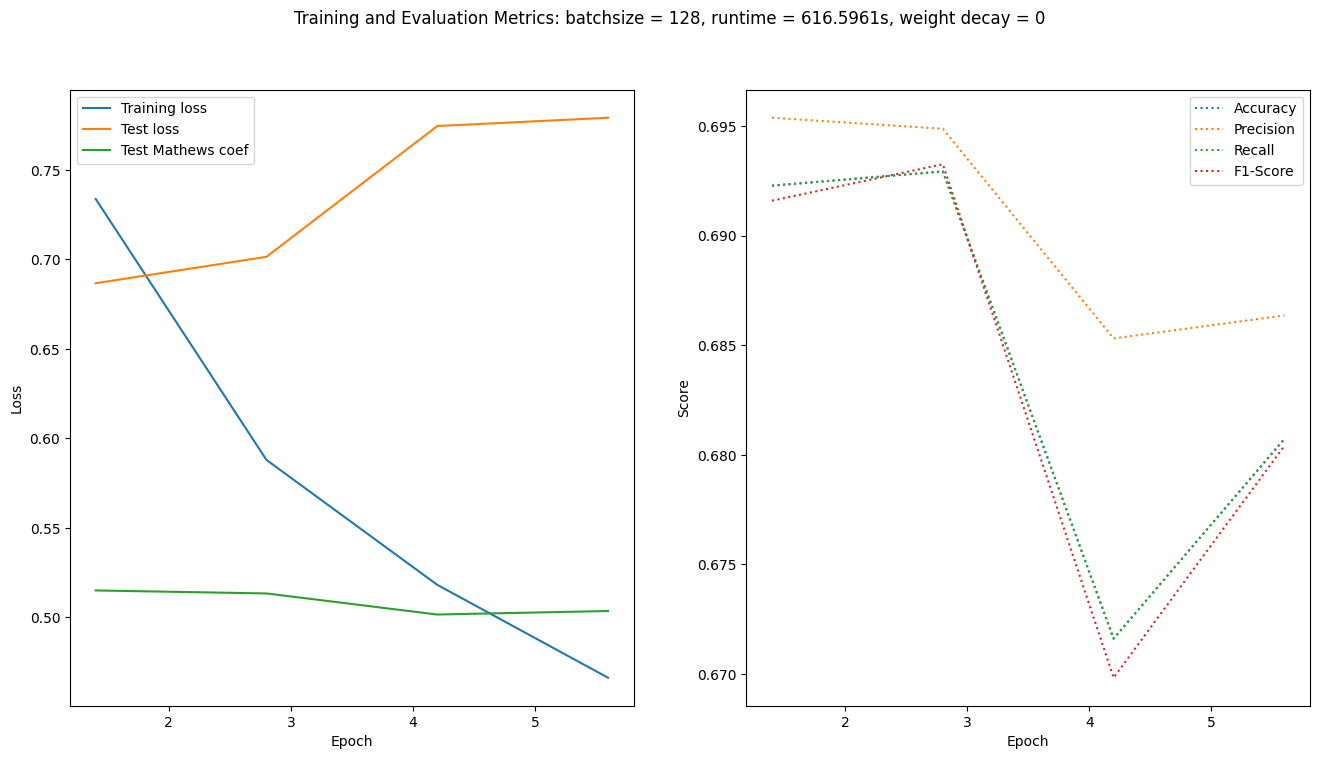

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6362291574478149,
 'eval_accuracy': 0.729,
 'eval_precision': 0.7293400029099201,
 'eval_recall': 0.729,
 'eval_f1': 0.7289925781220302,
 'eval_mathews': 0.5640863400698115,
 'eval_runtime': 4.3251,
 'eval_samples_per_second': 462.413,
 'eval_steps_per_second': 57.802,
 'epoch': 6.0}

In [ ]:
tbG = TestBench2(16,0)
report(tbG,16, 0)
tbG.trainer.evaluate(val_dataset)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/4278 [00:00<?, ?it/s]

{'loss': 0.7736, 'learning_rate': 4.415614773258532e-05, 'epoch': 0.7}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7406436204910278, 'eval_accuracy': 0.6749430153044611, 'eval_precision': 0.6804212921317292, 'eval_recall': 0.6749430153044611, 'eval_f1': 0.6758230047026332, 'eval_mathews': 0.48885894305702365, 'eval_runtime': 25.764, 'eval_samples_per_second': 476.789, 'eval_steps_per_second': 59.618, 'epoch': 0.7}
{'loss': 0.6392, 'learning_rate': 3.831229546517064e-05, 'epoch': 1.4}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.6969035863876343, 'eval_accuracy': 0.688944969065451, 'eval_precision': 0.689772416973183, 'eval_recall': 0.688944969065451, 'eval_f1': 0.6888736582380713, 'eval_mathews': 0.5060113628984108, 'eval_runtime': 25.5234, 'eval_samples_per_second': 481.284, 'eval_steps_per_second': 60.18, 'epoch': 1.4}
{'loss': 0.5951, 'learning_rate': 3.246844319775596e-05, 'epoch': 2.1}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7188531756401062, 'eval_accuracy': 0.6828394659719961, 'eval_precision': 0.6893513984993943, 'eval_recall': 0.6828394659719961, 'eval_f1': 0.6822498172531484, 'eval_mathews': 0.5084864211187851, 'eval_runtime': 25.6921, 'eval_samples_per_second': 478.124, 'eval_steps_per_second': 59.785, 'epoch': 2.1}
{'loss': 0.5399, 'learning_rate': 2.6624590930341282e-05, 'epoch': 2.81}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7023807168006897, 'eval_accuracy': 0.6929338977531748, 'eval_precision': 0.6937651873129871, 'eval_recall': 0.6929338977531748, 'eval_f1': 0.6929914462317867, 'eval_mathews': 0.5124220773041348, 'eval_runtime': 25.7839, 'eval_samples_per_second': 476.422, 'eval_steps_per_second': 59.572, 'epoch': 2.81}
{'loss': 0.4974, 'learning_rate': 2.0780738662926602e-05, 'epoch': 3.51}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7782450914382935, 'eval_accuracy': 0.6841419732985998, 'eval_precision': 0.6855262237870358, 'eval_recall': 0.6841419732985998, 'eval_f1': 0.6843218295129248, 'eval_mathews': 0.49969676765388293, 'eval_runtime': 25.92, 'eval_samples_per_second': 473.919, 'eval_steps_per_second': 59.259, 'epoch': 3.51}
{'loss': 0.4596, 'learning_rate': 1.4936886395511924e-05, 'epoch': 4.21}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8079522848129272, 'eval_accuracy': 0.6740475415174211, 'eval_precision': 0.6794373788914954, 'eval_recall': 0.6740475415174211, 'eval_f1': 0.6737620924452024, 'eval_mathews': 0.4929983440615915, 'eval_runtime': 26.0732, 'eval_samples_per_second': 471.135, 'eval_steps_per_second': 58.911, 'epoch': 4.21}
{'loss': 0.427, 'learning_rate': 9.093034128097242e-06, 'epoch': 4.91}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8055081367492676, 'eval_accuracy': 0.6735591012699447, 'eval_precision': 0.681668254860371, 'eval_recall': 0.6735591012699447, 'eval_f1': 0.671920579346117, 'eval_mathews': 0.49700881545576076, 'eval_runtime': 25.8488, 'eval_samples_per_second': 475.225, 'eval_steps_per_second': 59.422, 'epoch': 4.91}
{'loss': 0.3909, 'learning_rate': 3.2491818606825616e-06, 'epoch': 5.61}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8430057168006897, 'eval_accuracy': 0.6829208726799089, 'eval_precision': 0.6844790021242566, 'eval_recall': 0.6829208726799089, 'eval_f1': 0.6829589885423182, 'eval_mathews': 0.49872990194546846, 'eval_runtime': 25.9443, 'eval_samples_per_second': 473.476, 'eval_steps_per_second': 59.204, 'epoch': 5.61}
{'train_runtime': 832.6426, 'train_samples_per_second': 328.7, 'train_steps_per_second': 5.138, 'train_loss': 0.5304762870142983, 'epoch': 6.0}


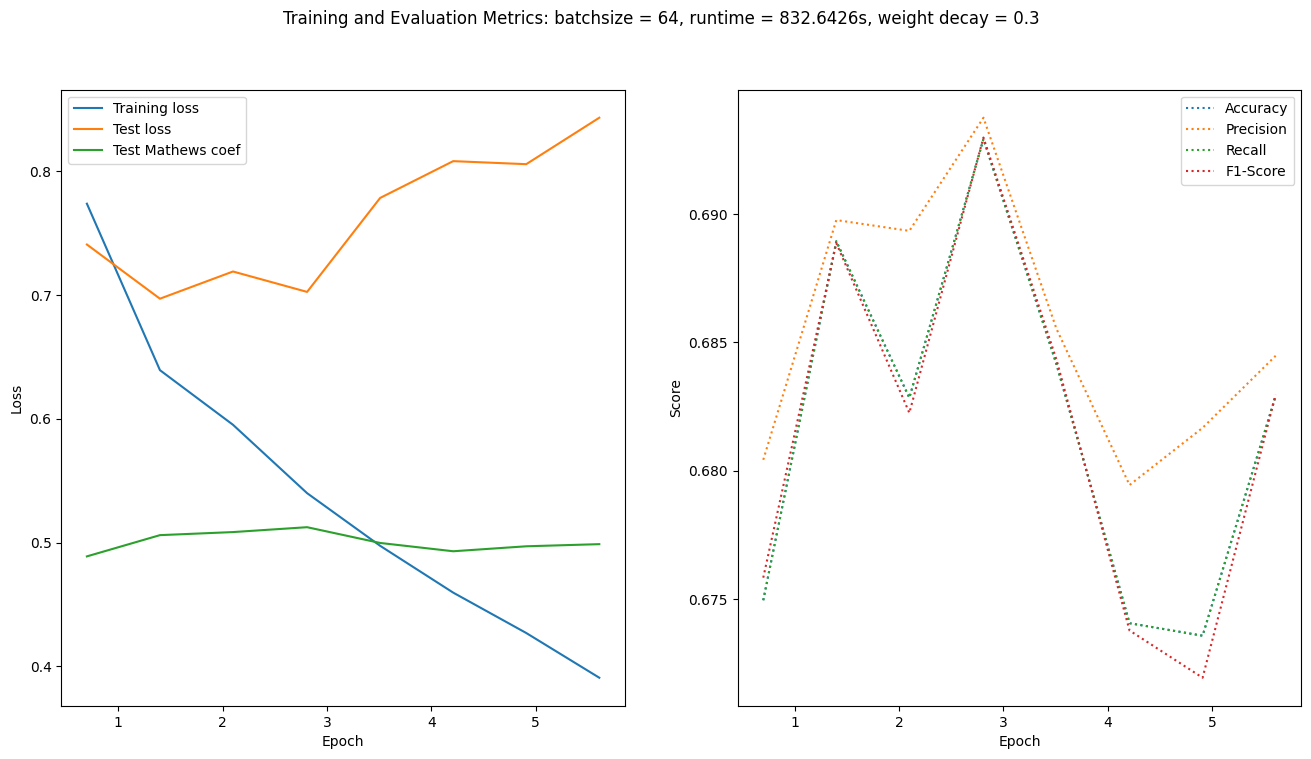

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6437342166900635,
 'eval_accuracy': 0.726,
 'eval_precision': 0.72914593384526,
 'eval_recall': 0.726,
 'eval_f1': 0.7270543673072555,
 'eval_mathews': 0.5617103570592977,
 'eval_runtime': 4.3964,
 'eval_samples_per_second': 454.917,
 'eval_steps_per_second': 56.865,
 'epoch': 6.0}

In [92]:
tbH = TestBench2(64,0.3)
report(tbH, 64, 0.3)
tbH.trainer.evaluate(val_dataset)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

  0%|          | 0/14260 [00:00<?, ?it/s]

{'loss': 0.7791, 'learning_rate': 4.82468443197756e-05, 'epoch': 0.7}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.73876953125, 'eval_accuracy': 0.6769781830022794, 'eval_precision': 0.6812434994826195, 'eval_recall': 0.6769781830022794, 'eval_f1': 0.6775287544287986, 'eval_mathews': 0.48845619303924953, 'eval_runtime': 25.813, 'eval_samples_per_second': 475.885, 'eval_steps_per_second': 59.505, 'epoch': 0.7}
{'loss': 0.6369, 'learning_rate': 4.649368863955119e-05, 'epoch': 1.4}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7066835165023804, 'eval_accuracy': 0.6848746336698144, 'eval_precision': 0.684836160841907, 'eval_recall': 0.6848746336698144, 'eval_f1': 0.6848452062323265, 'eval_mathews': 0.49477051159809515, 'eval_runtime': 25.8337, 'eval_samples_per_second': 475.503, 'eval_steps_per_second': 59.457, 'epoch': 1.4}
{'loss': 0.5933, 'learning_rate': 4.474053295932679e-05, 'epoch': 2.1}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7468898296356201, 'eval_accuracy': 0.6769781830022794, 'eval_precision': 0.6826433870816725, 'eval_recall': 0.6769781830022794, 'eval_f1': 0.67726602707646, 'eval_mathews': 0.49637161683139114, 'eval_runtime': 25.9363, 'eval_samples_per_second': 473.623, 'eval_steps_per_second': 59.222, 'epoch': 2.1}
{'loss': 0.5332, 'learning_rate': 4.298737727910239e-05, 'epoch': 2.81}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.7493466138839722, 'eval_accuracy': 0.6836535330511234, 'eval_precision': 0.687720817821407, 'eval_recall': 0.6836535330511234, 'eval_f1': 0.6828232948457154, 'eval_mathews': 0.4924241560551303, 'eval_runtime': 25.7684, 'eval_samples_per_second': 476.709, 'eval_steps_per_second': 59.608, 'epoch': 2.81}
{'loss': 0.4852, 'learning_rate': 4.123422159887798e-05, 'epoch': 3.51}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8256471157073975, 'eval_accuracy': 0.6789319439921849, 'eval_precision': 0.6821568562424182, 'eval_recall': 0.6789319439921849, 'eval_f1': 0.678652246926497, 'eval_mathews': 0.49655783968898587, 'eval_runtime': 25.7989, 'eval_samples_per_second': 476.143, 'eval_steps_per_second': 59.537, 'epoch': 3.51}
{'loss': 0.4448, 'learning_rate': 3.9481065918653576e-05, 'epoch': 4.21}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.855073869228363, 'eval_accuracy': 0.6812113318137415, 'eval_precision': 0.6827932097155884, 'eval_recall': 0.6812113318137415, 'eval_f1': 0.6815467221859245, 'eval_mathews': 0.49357190353127767, 'eval_runtime': 25.7252, 'eval_samples_per_second': 477.508, 'eval_steps_per_second': 59.708, 'epoch': 4.21}
{'loss': 0.4011, 'learning_rate': 3.772791023842918e-05, 'epoch': 4.91}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.8448386788368225, 'eval_accuracy': 0.6761641159231521, 'eval_precision': 0.6782312587323719, 'eval_recall': 0.6761641159231521, 'eval_f1': 0.6762866428677595, 'eval_mathews': 0.4890441184488428, 'eval_runtime': 25.7708, 'eval_samples_per_second': 476.664, 'eval_steps_per_second': 59.602, 'epoch': 4.91}
{'loss': 0.3415, 'learning_rate': 3.597475455820477e-05, 'epoch': 5.61}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 0.944303572177887, 'eval_accuracy': 0.6692445457505698, 'eval_precision': 0.6716124465352474, 'eval_recall': 0.6692445457505698, 'eval_f1': 0.6694693072715407, 'eval_mathews': 0.47845946506618575, 'eval_runtime': 25.9948, 'eval_samples_per_second': 472.557, 'eval_steps_per_second': 59.089, 'epoch': 5.61}
{'loss': 0.3203, 'learning_rate': 3.4221598877980366e-05, 'epoch': 6.31}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.0356777906417847, 'eval_accuracy': 0.6609410615434712, 'eval_precision': 0.6671884250948417, 'eval_recall': 0.6609410615434712, 'eval_f1': 0.6592766109830488, 'eval_mathews': 0.4754584386636639, 'eval_runtime': 25.742, 'eval_samples_per_second': 477.197, 'eval_steps_per_second': 59.669, 'epoch': 6.31}
{'loss': 0.2905, 'learning_rate': 3.246844319775596e-05, 'epoch': 7.01}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.0338314771652222, 'eval_accuracy': 0.6667209378052752, 'eval_precision': 0.6684184742491984, 'eval_recall': 0.6667209378052752, 'eval_f1': 0.6668778270026757, 'eval_mathews': 0.4731112859490744, 'eval_runtime': 25.7368, 'eval_samples_per_second': 477.294, 'eval_steps_per_second': 59.681, 'epoch': 7.01}
{'loss': 0.247, 'learning_rate': 3.071528751753156e-05, 'epoch': 7.71}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.0814824104309082, 'eval_accuracy': 0.6687561055030935, 'eval_precision': 0.6708049646627035, 'eval_recall': 0.6687561055030935, 'eval_f1': 0.6686095163058121, 'eval_mathews': 0.4782813823942754, 'eval_runtime': 25.9101, 'eval_samples_per_second': 474.1, 'eval_steps_per_second': 59.282, 'epoch': 7.71}
{'loss': 0.233, 'learning_rate': 2.8962131837307156e-05, 'epoch': 8.42}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.1411750316619873, 'eval_accuracy': 0.6775480299576685, 'eval_precision': 0.6791366564241109, 'eval_recall': 0.6775480299576685, 'eval_f1': 0.6768638293482995, 'eval_mathews': 0.47898323446799845, 'eval_runtime': 25.8381, 'eval_samples_per_second': 475.423, 'eval_steps_per_second': 59.447, 'epoch': 8.42}
{'loss': 0.2146, 'learning_rate': 2.720897615708275e-05, 'epoch': 9.12}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.2526832818984985, 'eval_accuracy': 0.6667209378052752, 'eval_precision': 0.6699366155295228, 'eval_recall': 0.6667209378052752, 'eval_f1': 0.666938897922961, 'eval_mathews': 0.46867289026591913, 'eval_runtime': 25.2188, 'eval_samples_per_second': 487.098, 'eval_steps_per_second': 60.907, 'epoch': 9.12}
{'loss': 0.1881, 'learning_rate': 2.5455820476858346e-05, 'epoch': 9.82}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.315279245376587, 'eval_accuracy': 0.6520677303809834, 'eval_precision': 0.6607475301780721, 'eval_recall': 0.6520677303809834, 'eval_f1': 0.65265585667498, 'eval_mathews': 0.46020124866801476, 'eval_runtime': 25.504, 'eval_samples_per_second': 481.649, 'eval_steps_per_second': 60.226, 'epoch': 9.82}
{'loss': 0.1702, 'learning_rate': 2.3702664796633942e-05, 'epoch': 10.52}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.376652479171753, 'eval_accuracy': 0.6646043633995441, 'eval_precision': 0.669328955360286, 'eval_recall': 0.6646043633995441, 'eval_f1': 0.664406552865908, 'eval_mathews': 0.46430122732502177, 'eval_runtime': 25.2976, 'eval_samples_per_second': 485.58, 'eval_steps_per_second': 60.717, 'epoch': 10.52}
{'loss': 0.1637, 'learning_rate': 2.194950911640954e-05, 'epoch': 11.22}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.3680455684661865, 'eval_accuracy': 0.6614295017909476, 'eval_precision': 0.6629156050507471, 'eval_recall': 0.6614295017909476, 'eval_f1': 0.661503649133489, 'eval_mathews': 0.4646658628492338, 'eval_runtime': 25.3032, 'eval_samples_per_second': 485.472, 'eval_steps_per_second': 60.704, 'epoch': 11.22}
{'loss': 0.1419, 'learning_rate': 2.0196353436185132e-05, 'epoch': 11.92}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.439156413078308, 'eval_accuracy': 0.6586616737219146, 'eval_precision': 0.6629427745491546, 'eval_recall': 0.6586616737219146, 'eval_f1': 0.6590717799157145, 'eval_mathews': 0.4640399861521933, 'eval_runtime': 25.3843, 'eval_samples_per_second': 483.922, 'eval_steps_per_second': 60.51, 'epoch': 11.92}
{'loss': 0.1313, 'learning_rate': 1.8443197755960732e-05, 'epoch': 12.62}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.450910210609436, 'eval_accuracy': 0.6634646694887659, 'eval_precision': 0.6655321039598607, 'eval_recall': 0.6634646694887659, 'eval_f1': 0.6637797737559312, 'eval_mathews': 0.4678347629041479, 'eval_runtime': 25.2825, 'eval_samples_per_second': 485.87, 'eval_steps_per_second': 60.754, 'epoch': 12.62}
{'loss': 0.1252, 'learning_rate': 1.6690042075736325e-05, 'epoch': 13.32}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.55514657497406, 'eval_accuracy': 0.6542657114946272, 'eval_precision': 0.6611107212967956, 'eval_recall': 0.6542657114946272, 'eval_f1': 0.6548978633302192, 'eval_mathews': 0.45548740758228035, 'eval_runtime': 25.3378, 'eval_samples_per_second': 484.809, 'eval_steps_per_second': 60.621, 'epoch': 13.32}
{'loss': 0.11, 'learning_rate': 1.4936886395511924e-05, 'epoch': 14.03}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.5154491662979126, 'eval_accuracy': 0.6667209378052752, 'eval_precision': 0.6677854166348799, 'eval_recall': 0.6667209378052752, 'eval_f1': 0.666958621784874, 'eval_mathews': 0.4701364177298386, 'eval_runtime': 25.3117, 'eval_samples_per_second': 485.309, 'eval_steps_per_second': 60.683, 'epoch': 14.03}
{'loss': 0.1005, 'learning_rate': 1.3183730715287517e-05, 'epoch': 14.73}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.600385069847107, 'eval_accuracy': 0.6628948225333767, 'eval_precision': 0.6651277013896412, 'eval_recall': 0.6628948225333767, 'eval_f1': 0.6632866966910789, 'eval_mathews': 0.4669356617294287, 'eval_runtime': 25.399, 'eval_samples_per_second': 483.641, 'eval_steps_per_second': 60.475, 'epoch': 14.73}
{'loss': 0.1026, 'learning_rate': 1.1430575035063114e-05, 'epoch': 15.43}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.6244686841964722, 'eval_accuracy': 0.6579290133507001, 'eval_precision': 0.6625910106019015, 'eval_recall': 0.6579290133507001, 'eval_f1': 0.6581995032635944, 'eval_mathews': 0.46495591398401687, 'eval_runtime': 25.4078, 'eval_samples_per_second': 483.473, 'eval_steps_per_second': 60.454, 'epoch': 15.43}
{'loss': 0.0907, 'learning_rate': 9.67741935483871e-06, 'epoch': 16.13}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.658944845199585, 'eval_accuracy': 0.6624877889938131, 'eval_precision': 0.6640913956618625, 'eval_recall': 0.6624877889938131, 'eval_f1': 0.6628352517798609, 'eval_mathews': 0.4625199684609475, 'eval_runtime': 25.5345, 'eval_samples_per_second': 481.075, 'eval_steps_per_second': 60.154, 'epoch': 16.13}
{'loss': 0.0843, 'learning_rate': 7.924263674614305e-06, 'epoch': 16.83}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.6609598398208618, 'eval_accuracy': 0.6660696841419733, 'eval_precision': 0.6664159929122666, 'eval_recall': 0.6660696841419733, 'eval_f1': 0.666182069190257, 'eval_mathews': 0.4661218270680895, 'eval_runtime': 25.2645, 'eval_samples_per_second': 486.217, 'eval_steps_per_second': 60.797, 'epoch': 16.83}
{'loss': 0.0756, 'learning_rate': 6.171107994389902e-06, 'epoch': 17.53}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.724031686782837, 'eval_accuracy': 0.6618365353305112, 'eval_precision': 0.6642963248149532, 'eval_recall': 0.6618365353305112, 'eval_f1': 0.6622067976336231, 'eval_mathews': 0.46613849119576983, 'eval_runtime': 25.7208, 'eval_samples_per_second': 477.591, 'eval_steps_per_second': 59.718, 'epoch': 17.53}
{'loss': 0.0759, 'learning_rate': 4.417952314165498e-06, 'epoch': 18.23}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.7298319339752197, 'eval_accuracy': 0.6628948225333767, 'eval_precision': 0.6650687594157937, 'eval_recall': 0.6628948225333767, 'eval_f1': 0.6633009700312944, 'eval_mathews': 0.46420566178545625, 'eval_runtime': 25.5047, 'eval_samples_per_second': 481.637, 'eval_steps_per_second': 60.224, 'epoch': 18.23}
{'loss': 0.0719, 'learning_rate': 2.664796633941094e-06, 'epoch': 18.93}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.7540992498397827, 'eval_accuracy': 0.6637088896125041, 'eval_precision': 0.6668381192421032, 'eval_recall': 0.6637088896125041, 'eval_f1': 0.664050145801756, 'eval_mathews': 0.464528950946384, 'eval_runtime': 25.4927, 'eval_samples_per_second': 481.864, 'eval_steps_per_second': 60.253, 'epoch': 18.93}
{'loss': 0.0651, 'learning_rate': 9.1164095371669e-07, 'epoch': 19.64}


  0%|          | 0/1536 [00:00<?, ?it/s]

{'eval_loss': 1.778459906578064, 'eval_accuracy': 0.6639531097362422, 'eval_precision': 0.6669809837876027, 'eval_recall': 0.6639531097362422, 'eval_f1': 0.6644465398954059, 'eval_mathews': 0.4664417165618349, 'eval_runtime': 25.4294, 'eval_samples_per_second': 483.063, 'eval_steps_per_second': 60.403, 'epoch': 19.64}
{'train_runtime': 2789.3421, 'train_samples_per_second': 327.066, 'train_steps_per_second': 5.112, 'train_loss': 0.2542296238400324, 'epoch': 20.0}


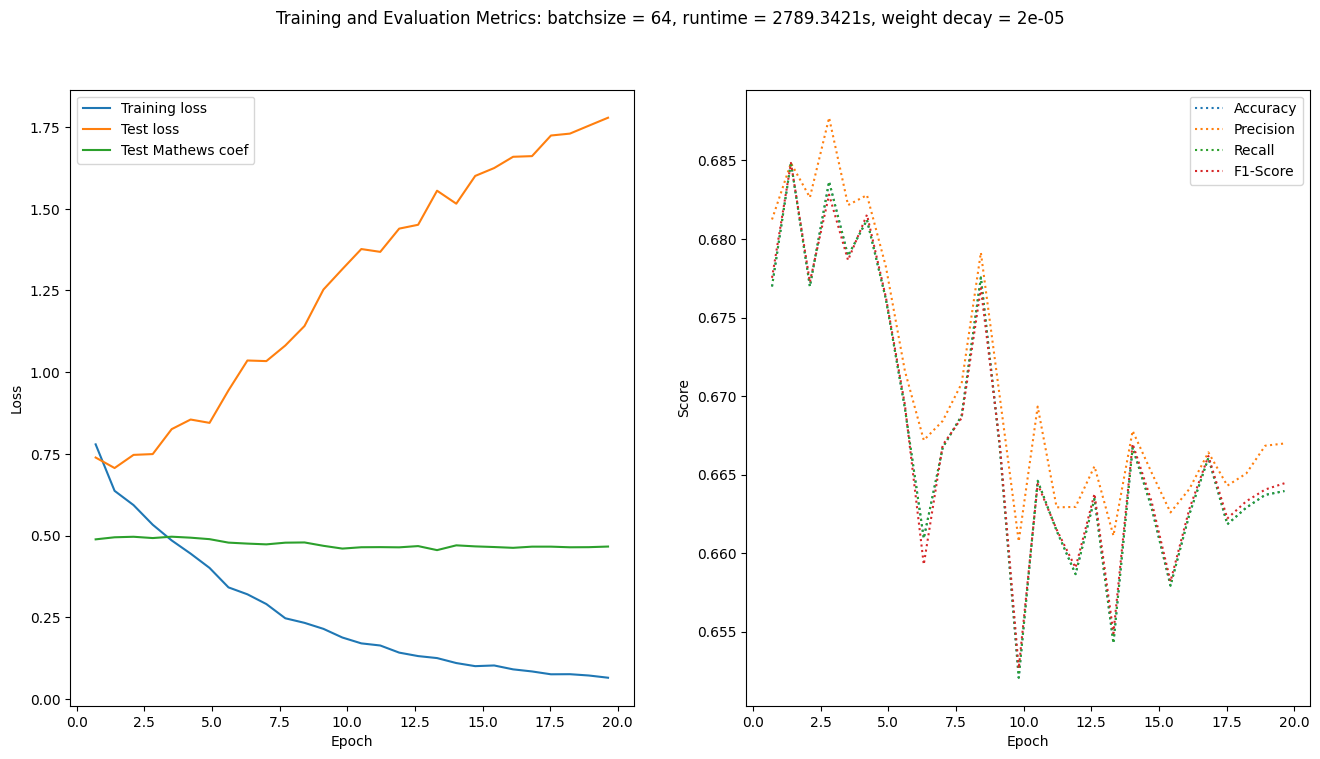

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.6371198892593384,
 'eval_accuracy': 0.7185,
 'eval_precision': 0.7249807756871642,
 'eval_recall': 0.7185,
 'eval_f1': 0.719948940639502,
 'eval_mathews': 0.5487445491167124,
 'eval_runtime': 4.2615,
 'eval_samples_per_second': 469.321,
 'eval_steps_per_second': 58.665,
 'epoch': 20.0}

In [93]:
#tbI = TestBench2(64 ,2e-5, epochs=20)
tbI.trainer.train()
report(tbI, 64, 2e-5)
tbI.trainer.evaluate(val_dataset)

In [ ]:
trs = {'batch32decay0.3':tbA, 'batch32decay0.001':tbB, 'batch64decay0.3':tbC, 'batch64decay0.001':tbD, 'batch128decay0.3':tbE, 'batch128decay0.001':tbF, 'batch128decay0':tbG, 'batch64decay0.001ep12':tbH, 'batvh128decay0.001ep12':tbI}
reportFinal(trs)

NameError: name 'tbF' is not defined